In [3]:
### Import packages ###
import time, sys, os
import h5py
import numpy as np
import astropy as ap
import scipy
import pandas
from matplotlib.pyplot import *

# Import packages to display SDSS optical image
from PIL import Image
import requests

# Import packages to open fits and calculate cosmology
from astropy.io import fits
from astropy.cosmology import WMAP9
import astropy.coordinates as coord
from astroquery.sdss import SDSS
from scipy.io import readsav

# Import prospector 
sys.path.insert(0, '/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/')
import prospect     #likelihood evaluations, parameter priors, and posterior sampling
from prospect.models.templates import TemplateLibrary
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.likelihood import chi_spec, chi_phot
from prospect.fitting import fit_model
from prospect.io import write_results as writer
import prospect.io.read_results as reader
# import fsps

import corner

# Import MCMC package
import emcee

# Import my build functions
from build_model_funct import build_model
from build_obs_funct_Win import build_obs
from FracSFH_ import FracSFH

import seaborn as sns
my_cmap = sns.color_palette("tab10")
import os
import tables

### re-defining plotting defaults for matplotlib
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})
rcParams.update({'axes.facecolor':'w'})
rcParams.update({'savefig.facecolor':'w'})
rcParams.update({'lines.linewidth':'0.7'})
rcParams.update({'font.size':'16'})

rcParams.update({'axes.prop_cycle': cycler(color = sns.color_palette("tab10"))})
%matplotlib inline

#DPI 

In [4]:
rcParams['figure.dpi'] = 300
# rcParams['font.size'] = 20


In [5]:
### Start Timer ###
start_time = time.time()

In [6]:
### Control for SEDs ###
Show_all_SEDS = False
Specific_galaxy = 10

Comp_Path = 'Comparison/G{}/'.format(Specific_galaxy)

if not os.path.exists('{}'.format(Comp_Path)):
    os.mkdir('{}'.format(Comp_Path))
Galaxy_Path = '{}'.format(Comp_Path)

print('This is for Galaxy ', Specific_galaxy)

ts = time.strftime("%y%b%d", time.localtime())
print('The Date is', ts)

This is for Galaxy  10
The Date is 21Nov10


In [7]:
### Constants ###
lsun = 3.846e33
pc = 3.085677581467192e18 # in cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.0 * np.pi * (pc*10)**2)
jansky_mks = 1e-26

### My Unit Functions ###
def mJy_to_maggies(mJy):
    """ Converts mJy to maggies
    """
    conversion_mJy_Jy = .001
    conversion_mJy_maggie = 3631
    return mJy * conversion_mJy_Jy/conversion_mJy_maggie

def f_nu_to_f_lambda_maggie(lam, f_nu):
    """ Converts f_nu (ergs) to f_lambda (maggies)
    """
    f_lambda_ergs = (10**-17 * f_nu) * (lam**2)/lightspeed
    f_lambda_mJy = (f_lambda_ergs / (1E-23)) * 1000
    f_lambda_maggie = mJy_to_maggies(f_lambda_mJy)
    return f_lambda_maggie

### From GitHub ###
def get_best_v2(res, **kwargs):
    """ Get the maximum a posteriori parameters.
    """
    imax = np.argmax(res['lnprobability'])
    try:
        i, j = np.unravel_index(imax, res['lnprobability'].shape)
        theta = res['chain'][i, j, :].copy()
    except(ValueError):
        theta = res['chain'][imax, :].copy()
        
    return  theta

def build_sps(zcontinuous=1, **extras):
    """ Build sps object using FracSFH basis
    """
    sps = FracSFH(zcontinuous = 1, **extras)         # run_params
    return sps

def zfrac_to_masses(total_mass=None, z_fraction=None, agebins=None, **extras):
    """This transforms from independent dimensionless `z` variables to sfr
    fractions and then to bin mass fractions. The transformation is such that
    sfr fractions are drawn from a Dirichlet prior.  See Betancourt et al. 2010
    and Leja et al. 2017
    :param total_mass:
        The total mass formed over all bins in the SFH.
    :param z_fraction:
        latent variables drawn form a specific set of Beta distributions. (see
        Betancourt 2010)
    :returns masses:
        The stellar mass formed in each age bin.
    """
    # sfr fractions
    sfr_fraction = np.zeros(len(z_fraction) + 1)
    sfr_fraction[0] = 1.0 - z_fraction[0]
    for i in range(1, len(z_fraction)):
        sfr_fraction[i] = np.prod(z_fraction[:i]) * (1.0 - z_fraction[i])
    sfr_fraction[-1] = 1 - np.sum(sfr_fraction[:-1])

    # convert to mass fractions
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    mass_fraction = sfr_fraction * np.array(time_per_bin)
    mass_fraction /= mass_fraction.sum()

    masses = total_mass * mass_fraction
    return masses


def zfrac_to_sfr(total_mass=None, z_fraction=None, agebins=None, **extras):
    """This transforms from independent dimensionless `z` variables to SFRs.
    :returns sfrs:
        The SFR in each age bin (msun/yr).
    """
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    masses = zfrac_to_masses(total_mass, z_fraction, agebins)
    return masses / time_per_bin

def best_vals(result_list):
    # print(corner.quantile(result_list[param_order], [0.16, 0.5, 0.84]))
    q_16, q_50, q_84 = corner.quantile(result_list, [0.16, 0.5, 0.84]) 
    dx_down, dx_up = q_50-q_16, q_84-q_50
    # return (np.around(q_50,2), np.around(dx_up,2), np.around(dx_down,2))
    return q_50, dx_up, dx_down

print('Packages and Functions Loaded')

Packages and Functions Loaded


In [8]:
### Load in Data file for all galaxies ###
AGN_file = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/asu.fit')
AGN_data = AGN_file[1].data

# GSL = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/galSpecLine-dr8.fits')
# GSL_data = GSL[1].data

# GSI = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/galSpecInfo-dr8.fits')
# GSI_data = GSI[1].data
# GSI_head = GSI[1].header

Cas_GSI = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/AGN_PSB_GalSpec_v1_Elitzer3.fit')
Cas_GSI_data = Cas_GSI[1].data
Cas_GSI[1].header

XTENSION= 'BINTABLE'                                                            
BITPIX  =                    8                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 4507                                                  
NAXIS2  =                   63                                                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
TFIELDS =                  795                                                  
TTYPE1  = 'recno'                                                               
TNULL1  =                  128                                                  
TFORM1  = '1B'                                                                  
TFORM2  = '1E'                                                                  
TTYPE2  = 'ra1'             

In [9]:
# for i in range(0, len(Cas_GSI_data['recno'])):
#     arrg = np.where(Cas_GSI_data['recno'] == i)
#     # print(arrg)
#     if len(arrg[0]) > 1:
#         print(arrg, Cas_GSI_data['recno'][i])
#         for ii in range(0,len(arrg[0])):
#             if Cas_GSI_data['sciencePrimary'][arrg[0][ii]] == 1:
#                 print(Cas_GSI_data['recno'][arrg[0][ii]], ' is 1') 
#             else:
#                 print(Cas_GSI_data['recno'][arrg[0][ii]], ' is 0')

for i in range(0, len(Cas_GSI_data['recno'])):
    if Cas_GSI_data['sciencePrimary'][i] ==0:
        print('science primary is 0 for ', Cas_GSI_data['recno'][i], 'at', i)
        arrg = np.where(Cas_GSI_data['recno'] == i)
        for ii in range(0, len(arrg[0])):
            if Cas_GSI_data['sciencePrimary'][arrg[0][ii]] == 1:
                print('\t ok!')
            else:
                print('\t Ahh 0!')

# Galaxy 49 does not have a scienceprimary of 1 at 60
scipri_array = [6, 13, 26, 42, 55] # array indecies of galaxies with sciprimary =0 with a scipri = 1 value (delete)
# scipri_array_gal = 

science primary is 0 for  57 at 6
	 ok!
science primary is 0 for  56 at 13
	 ok!
science primary is 0 for  50 at 26
	 ok!
science primary is 0 for  17 at 42
	 ok!
science primary is 0 for  29 at 55
	 ok!
science primary is 0 for  49 at 60


In [10]:
# Cas_GSI_data['NII_6584_FLUX']
# Cas_GSI_data['H_ALPHA_FLUX']
# Cas_GSI_data['OIII_5007_FLUX']
# Cas_GSI_data['H_BETA_FLUX']
# Cas_GSI_data['NII_6584_FLUX']
# Cas_GSI_data['sn_median']


# xalli = np.divide(Cas_GSI_data['NII_6584_FLUX'], Cas_GSI_data['H_ALPHA_FLUX'], 
#     out = np.zeros_like(Cas_GSI_data['NII_6584_FLUX']), where=(Cas_GSI_data['H_ALPHA_FLUX'] != 0))

# yalli = np.divide(Cas_GSI_data['OIII_5007_FLUX'], Cas_GSI_data['H_BETA_FLUX'], 
#     out = np.zeros_like(Cas_GSI_data['OIII_5007_FLUX']), where=(Cas_GSI_data['H_BETA_FLUX'] != 0))

# usefulness = np.where((xalli > 0) & (yalli > 0) )

# xall = xalli[usefulness]
# yall = yalli[usefulness]

# Cas_GSI_data_masked = Cas_GSI_data[usefulness]

# scatter(np.log10(xall), np.log10(yall))         # need to remove scipri = 0 for scipri_array

In [11]:
# crit1 = np.log10(yall) - np.log10(xall) * np.tan((90 - 25) * np.pi/180)
# crit2 = (np.log10(yall) - 1.19) * (np.log10(xall)-0.47)
# n_seyferts = np.where((crit1 > .45) & (crit2 < 0.61))
# n_sf = np.where(crit2 > 0.61)
# n_liner = np.where((crit1 < 0.45) & (crit2 < 0.61))

# Cas_GSI_data_masked = Cas_GSI_data[usefulness]

In [12]:
# scatter(np.log10(xall), np.log10(yall))         # need to remove scipri = 0 for scipri_array

In [13]:
### Find all h5 files in Galaxy_output directory and subdirectories and append to h5files ###
h5_path = '/mnt/c/Users/emma_d/ASTR_Research/Galaxy_output/CAPS_Output' # CHANGE BACK!

h5files = []
h5files_dir = []
for dirpath, subdirs, files in os.walk(h5_path):
    for y in subdirs:
        for dirpath, subdirs, files in os.walk(h5_path + '/' + str(y)):
            for x in files:
                if x.endswith("5.h5"):
                    h5files.append(os.path.join(dirpath, x))
# print(h5files)

In [14]:
### Load in data from h5file ###
all_results = []
# all_obs = []
# all_sps = []
# all_model = []

zred_a = []
# wphot = []
# wspec = []

theta_bestfit = []
# mspec_map = []
# mphot_map = []

# mspec_agn_inv = []
# mphot_agn_inv = []

RA_array = []
DEC_array = []

Gal_desig = []
Gal_logmass = []
Gal_data = []

names = []
G_names = []
G_numbers = []
num_runs = len(h5files)
progress_meter = 1
for i in range(0, len(h5files)):
    names.append(os.path.basename(h5files[i]))

    if names[i][2] == '_':
        G_names.append(names[i][0:2])
    else:
        G_names.append(names[i][0:3])
    
    G_numbers.append(int(G_names[i][1:]))
    number_g = int(G_names[i][1:])

    Gal_data.append(AGN_data[number_g])
    Gal_desig.append(Gal_data[i][1])
    Gal_logmass.append(Gal_data[i][50])

    all_results.append(reader.results_from(h5files[i], dangerous=False)[0]) # Everything here is sorted by i (hfile read in order)
    # all_obs.append(reader.results_from(h5files[i], dangerous=False)[1])
    # all_sps.append(build_sps(**all_results[i]['run_params']))
    # all_model.append(build_model(**all_results[i]['run_params']))
    
    theta_bestfit.append(all_results[i]['bestfit']['parameter'])

    agn_only_theta = theta_bestfit[i].copy()
    agn_only_theta[13] = 0

    no_AGN_theta = all_results[i]['bestfit']['parameter'].copy()
    no_AGN_theta[13] = 0
    # No_AGN_model = build_model(**all_results[i]['run_params'])
    # mspec_agn_inv.append(No_AGN_model.mean_model(no_AGN_theta, all_obs[i], sps=all_sps[i])[0])      # mspec_agn_inv
    # mphot_agn_inv.append(No_AGN_model.mean_model(no_AGN_theta, all_obs[i], sps=all_sps[i])[1])
    
    redshift = next(item for item in all_results[i]['model_params'] if item["name"] == "zred")
    zred_a.append(1.0 + redshift['init'])
    
    RA_array.append(all_results[i]['run_params']['SDSS_Query']['ra'][0])
    DEC_array.append(all_results[i]['run_params']['SDSS_Query']['dec'][0])

    # wphot.append(all_obs[i]['phot_wave'])

    # wspec_wave = all_sps[i].wavelengths
    # wspec.append(zred_a[i] * wspec_wave)

    # mean_model = all_model[i].mean_model(theta_bestfit[i], all_obs[i], sps=all_sps[i])
    # mspec_map.append(mean_model[0])
    # mphot_map.append(mean_model[1])

    print(G_names[i], Gal_desig[i], Gal_logmass[i], '\t{:.0f}'.format(progress_meter/num_runs * 100),'% Done loading file data')
    progress_meter += 1

tables.file._open_files.close_all()
print('There are',num_runs, 'runs')
print('Finished')

G0 R1 9.82 	2 % Done loading file data
G1 R2 10.63 	4 % Done loading file data
G10 EAH02 10.39 	5 % Done loading file data
G11 EAH03 10.34 	7 % Done loading file data
G12 EAH04 10.18 	9 % Done loading file data
G13 EAH05 10.81 	11 % Done loading file data
G14 EAH06 10.12 	12 % Done loading file data
G15 EAH07 9.88 	14 % Done loading file data
G16 EAH08 10.07 	16 % Done loading file data
G17 EAH09 11.01 	18 % Done loading file data
G18 EAH10 10.24 	20 % Done loading file data
G19 EAH11 10.64 	21 % Done loading file data
G2 R3 9.63 	23 % Done loading file data
G20 EAH12 9.89 	25 % Done loading file data
G21 EAH13 11.0 	27 % Done loading file data
G22 EAH14 10.04 	29 % Done loading file data


In [ ]:
# GSI_G_Mask = []
# GSI_ra_Gal_Mask = []
# GSI_dec_Gal_Mask = []
# GSI_Gal_Masks = []
# GSI_QA_Mask = []
# GSI_Type_Mask = []
# GSI_G_Mask = []


# GSI_G_Mask = (GSI_data['RELEASE'] != 'extra')*(GSI_data['RELEASE'] != 'special')
# GSI_Type_Mask = (GSI_data['TARGETTYPE'] == 'GALAXY') + ( GSI_data['SPECTROTYPE'] == 'GALAXY')
# GSI_QA_Mask = (GSI_data['TARGETTYPE'] != 'QA') + (GSI_data['SPECTROTYPE'] != 'QA')
# Coord_error = .002

# for i in range(0, len(G_numbers)):
#     # print( AGN_data[int(G_names[i][1:])][2])
#     RA = AGN_data[int(G_names[i][1:])][2]        #RA_array[i]
#     DEC =AGN_data[int(G_names[i][1:])][3]       #DEC_array[i]
#     # GSI_ra_Gal_Mask =  RA_array[i] - Coord_error <= GSI_data['RA'] <= RA_array[i] + Coord_error
#     GSI_ra_Gal_Mask = (RA - Coord_error < GSI_data['RA'])*(GSI_data['RA'] < RA + Coord_error)
#     # GSI_dec_Gal_Mask = DEC_array[i] - Coord_error <= GSI_data['DEC'] <= DEC_array[i] + Coord_error
#     GSI_dec_Gal_Mask = (DEC - Coord_error < GSI_data['DEC'])*(GSI_data['DEC'] < DEC + Coord_error)

#     # GSI_Gal_Masks = GSI_G_Mask & GSI_ra_Gal_Mask & GSI_dec_Gal_Mask

#     # GSI_Gal_Masks = [GSI_G_Mask & GSI_ra_Gal_Mask & GSI_dec_Gal_Mask]
#     # print(GSI_data[GSI_Gal_Masks])

#     # print(GSI_G_Mask)

#     # GSI_data_1 = GSI_data[GSI_G_Mask]
#     # # print(GSI_data_1)
#     # GSI_data_2 = GSI_data_1[GSI_ra_Gal_Mask]
#     # GSI_data_3 = GSI_data_2[GSI_dec_Gal_Mask]


#     GSI_data_i = GSI_data[GSI_ra_Gal_Mask*GSI_dec_Gal_Mask*GSI_G_Mask*GSI_Type_Mask*GSI_QA_Mask] # GSI_G_Mask

#     # GSI_Gals = GSI_data[GSI_Gal_Masks]
#     print(G_names[i], GSI_data_i) #GSI_data_i['TARGETTYPE'], GSI_data_i['SPECTROTYPE'], GSI_data_i['RELEASE'])
#     # print(GSI_data_3)   

In [ ]:
# for i in range(0,len(h5files)):
#     try:
#         print(all_results[i]['run_params']['ts'], G_names[i])
#     except:
#         print('No ts available for', os.path.basename(h5files[i]))
#     try:
#         print(all_results[i]['run_params']['ra_labels'])
#     except:
#         print('No ra_labels available')

# G_numbers

In [ ]:
### Plot SEDs of galaxy runs ###
# Will not work in current configuration

# if Show_all_SEDS == True:
#       ymin = 1.5 * (10**-10)
#       xmin = 1222.447801222852 
#       xmax = 6164346.25 
#       ymax = 0.0005315684384467088

#       fig, axes = subplots(nrows= num_runs, ncols = 1, sharex=True, sharey=True, figsize=(16, 2 * num_runs), dpi=300)
#       gs = gridspec.GridSpec(num_runs, 1, hspace=0.0) 

#       ax_counter = 0

#       for ax in axes.flat:
#             ax= subplot(gs[ax_counter])
#             ax.loglog(wspec[ax_counter] * zred_a[ax_counter], mspec_map[ax_counter], 
#                   label='Model spectrum (MAP)',lw=0.7,  alpha=0.7, color = my_cmap[0]) 
            
#             ax.errorbar(wphot[ax_counter], mphot_map[ax_counter], 
#                   label='Model photometry (MAP)', marker='s', markersize=10, alpha=0.8, 
#                   ls='', lw=3,  markerfacecolor='none', color = my_cmap[0], markeredgewidth=3) 
            
#             ax.errorbar(wphot[ax_counter], all_obs[ax_counter]['maggies'], 
#                   yerr=all_obs[ax_counter]['maggies_unc'], label='Observed photometry', 
#                   ecolor= my_cmap[3], marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
#                   markerfacecolor='none', markeredgecolor=my_cmap[3], markeredgewidth=3)
            
#             ax.legend(title=G_names[ax_counter], loc=2)
            
#             ax.set_xlim([xmin, xmax])
#             ax.set_ylim([ymin, ymax])
#             ax_counter +=1

#       ax.set_xlabel('Wavelength [A]')
#       tight_layout()
# else:
#       print('Show_all_SEDs is False. \nTo see SEDs for all runs, turn Show_all_SEDs to True')

In [ ]:
### Control for SEDs ###
Show_all_SEDS = False
Specific_galaxy = 28

Comp_Path = 'Comparison/G{}/'.format(Specific_galaxy)

if not os.path.exists('{}'.format(Comp_Path)):
    os.mkdir('{}'.format(Comp_Path))
Galaxy_Path = '{}'.format(Comp_Path)

print('This is for Galaxy ', Specific_galaxy)

ts = time.strftime("%y%b%d", time.localtime())
print('The Date is', ts)

This is for Galaxy  28
The Date is 21Oct19


In [ ]:
Specific_galaxy_index = []
if Specific_galaxy in G_numbers:
    for i in range(0,len(G_numbers)):
        if G_numbers[i] == Specific_galaxy:
            Specific_galaxy_index.append(i)
    print('There are', len(Specific_galaxy_index), 'runs for G{0}:\t{1}'.format(Specific_galaxy, Specific_galaxy_index))
else:
    print('There are no runs available for galaxy G{0}'.format(Specific_galaxy))

if len(Specific_galaxy_index) == 1:
    Specific_galaxy_index = Specific_galaxy_index[0]
    print('Specific_galaxy_index is', Specific_galaxy_index)
else: 
    print('Please Select Specific_galaxy_index manually from', Specific_galaxy_index)

There are 1 runs for G28:	[21]
Specific_galaxy_index is 21


In [ ]:
### Load in data from h5file ###
# Everything here is sorted by i (hfile read in order)
# all_obs.append(reader.results_from(h5files[i], dangerous=False)[1])
# all_sps.append(build_sps(**all_results[i]['run_params']))
# all_model.append(build_model(**all_results[i]['run_params']))


# No_AGN_model = build_model(**all_results[i]['run_params'])
# mspec_agn_inv.append(No_AGN_model.mean_model(no_AGN_theta, all_obs[i], sps=all_sps[i])[0])      # mspec_agn_inv
# mphot_agn_inv.append(No_AGN_model.mean_model(no_AGN_theta, all_obs[i], sps=all_sps[i])[1])


# wphot.append(all_obs[i]['phot_wave'])

# wspec_wave = all_sps[i].wavelengths
# wspec.append(zred_a[i] * wspec_wave)

# mean_model = all_model[i].mean_model(theta_bestfit[i], all_obs[i], sps=all_sps[i])
# mspec_map.append(mean_model[0])
# mphot_map.append(mean_model[1])
# ------------------------------------------------------------------------------------------

agn_only_theta = theta_bestfit[Specific_galaxy_index].copy()
agn_only_theta[13] = 0

no_AGN_theta = all_results[Specific_galaxy_index]['bestfit']['parameter'].copy()
no_AGN_theta[13] = 0


G_obs = reader.results_from(h5files[Specific_galaxy_index], dangerous=False)[1]
G_sps = build_sps(**all_results[Specific_galaxy_index]['run_params'])
G_model = build_model(**all_results[Specific_galaxy_index]['run_params'])

No_AGN_model = build_model(**all_results[Specific_galaxy_index]['run_params'])  #**all_results[Specific_galaxy_index]['run_params']
mspec_agn_inv = No_AGN_model.mean_model(no_AGN_theta, G_obs, sps=G_sps)[0]
mphot_agn_inv = No_AGN_model.mean_model(no_AGN_theta, G_obs, sps=G_sps)[1]
# Do I need a AGN only model???

wphot = G_obs['phot_wave']
wspec_wave = G_sps.wavelengths
wspec = zred_a[Specific_galaxy_index] * wspec_wave

mean_model = G_model.mean_model(theta_bestfit[Specific_galaxy_index], G_obs, sps=G_sps)
mspec_map = mean_model[0]
mphot_map = mean_model[1]

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

optical_spectrum = SDSS.get_spectra(plate= all_results[Specific_galaxy_index]['run_params']['SDSS_Query']['plate'][0], 
    fiberID= all_results[Specific_galaxy_index]['run_params']['SDSS_Query']['fiberID'][0], 
    mjd= all_results[Specific_galaxy_index]['run_params']['SDSS_Query']['mjd'][0])[0] 

/home/emma/.local/lib/python3.8/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


49.2288261673008 -0.0420029604670252


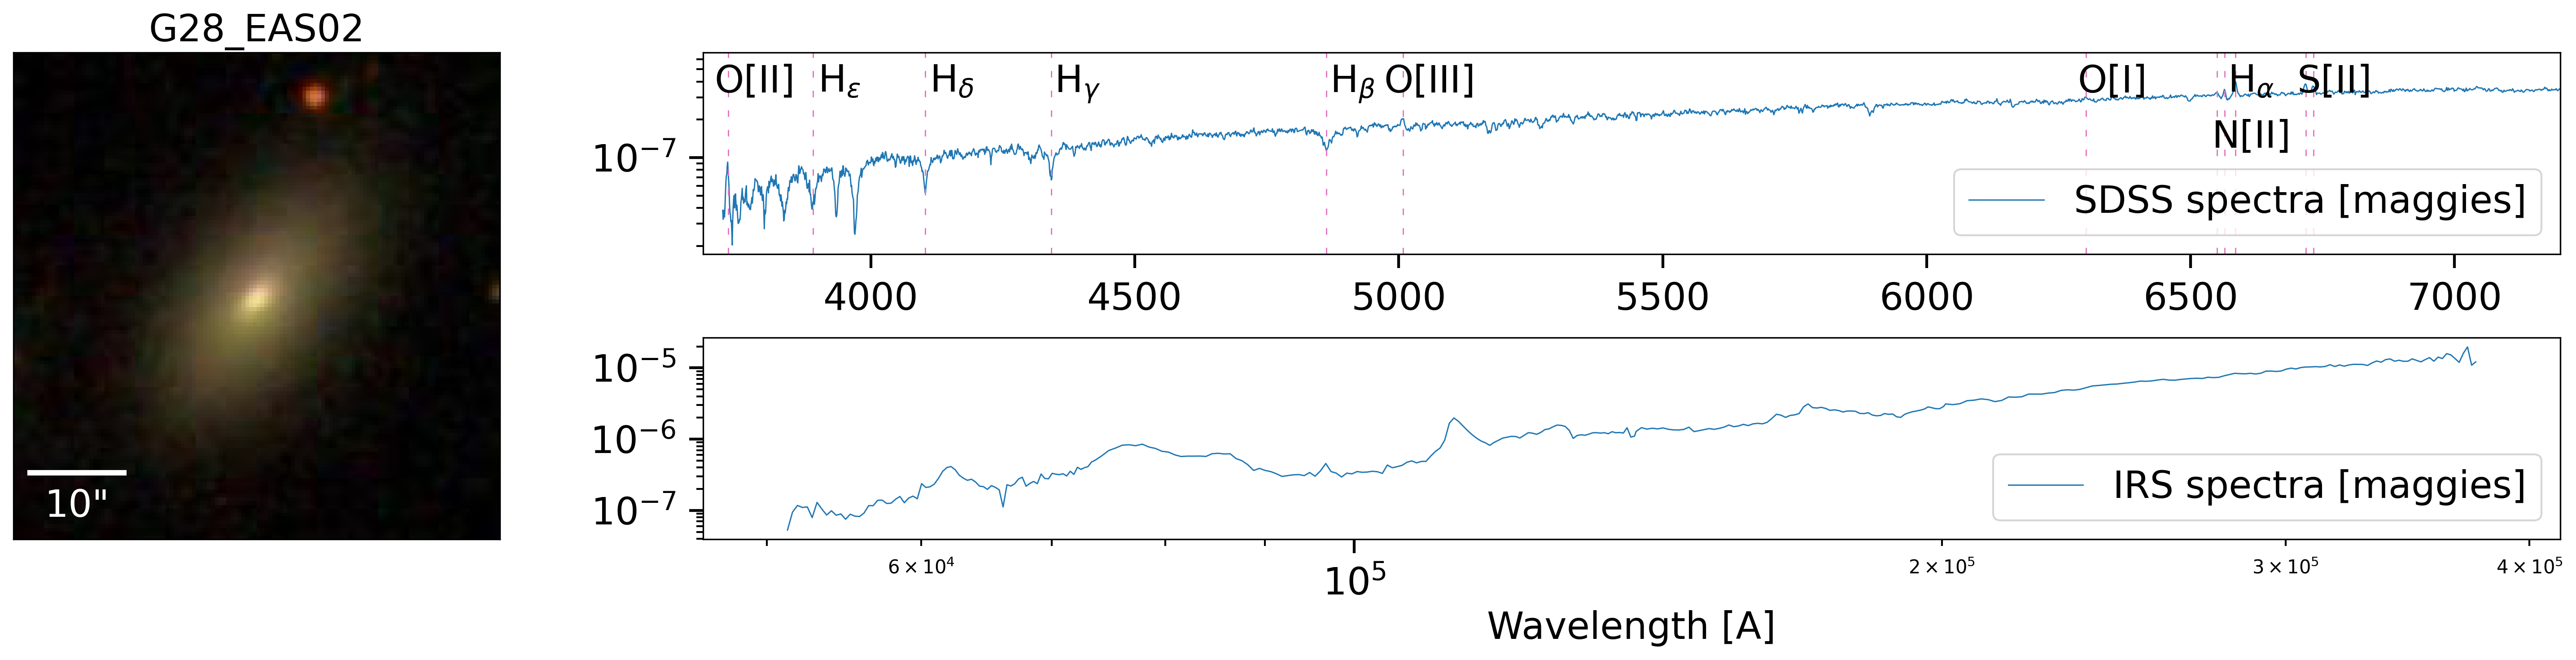

In [ ]:
### Grab SDSS Data ###
Gal_RA = all_results[Specific_galaxy_index]['run_params']['SDSS_Query']['ra'][0]
Gal_DEC = all_results[Specific_galaxy_index]['run_params']['SDSS_Query']['dec'][0]

SDSS_scale = 0.396127                   # arcsec/pix
SDSS_width = 128                        # SDSS_arcsec/SDSS_scale
SDSS_arcsec = SDSS_width * SDSS_scale   # arcsec 
SDSS_deg = SDSS_arcsec/3600             # deg

print(Gal_RA, Gal_DEC)

SDSS_URL = 'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.List&ra={0}&dec={1}&width={2}&height={2}&scale={3}'.format(Gal_RA, Gal_DEC, SDSS_width, SDSS_scale) # &width={2}&height={2}&scale={3}  : , SDSS_width, SDSS_scale
SDSS_Image = Image.open(requests.get(SDSS_URL, stream=True).raw)

optical_spectrum = SDSS.get_spectra(plate= all_results[Specific_galaxy_index]['run_params']['SDSS_Query']['plate'][0], 
    fiberID= all_results[Specific_galaxy_index]['run_params']['SDSS_Query']['fiberID'][0], 
    mjd= all_results[Specific_galaxy_index]['run_params']['SDSS_Query']['mjd'][0])[0] 

### Obtain optical spectrum in correct units###
optical_spectrum_flux = optical_spectrum[1].data['flux']
optical_spectrum_lam = 10 ** (optical_spectrum[1].data['loglam'])

# Find what units the data is in
units_flux = optical_spectrum[0].header['bunit']
units_wavelength_full = optical_spectrum[0].header['WAT1_001']
units_wavelength = units_wavelength_full[36:]

# Convert SDSS units to Prospector units
optical_spectrum_flux = f_nu_to_f_lambda_maggie(optical_spectrum_lam, optical_spectrum_flux)       
optical_spectrum_lam = optical_spectrum_lam / (1 + all_results[Specific_galaxy_index]['run_params']['object_redshift'])
optical_spectrum_lines = optical_spectrum[3].data

# ----------------------------------------------------------------------------------------------
### Grab IRS Data ###
if all_results[Specific_galaxy_index]['run_params']['IRS_indicator'] == 1:
    ea_struct = readsav('Data/ea_struct_v9.sav')['ea_struct']
    s1, = np.where(ea_struct.source.astype(str) == 'Spitzer')
    ea_struct = ea_struct[s1]

    gal_EA_Desig = all_results[Specific_galaxy_index]['run_params']['gal_desig'][2:]
    s, = np.where(ea_struct.ea_desig.astype(str) == gal_EA_Desig)

    # Convert Smercina units (mu*m,nu*f_nu) to prospector units (A, maggies)
    IRS_wavelength = ea_struct[s][0].irs_spectrum.wave * 10000
    IRS_flux = mJy_to_maggies(10**13 *(ea_struct[s][0].irs_spectrum.wave/(2.998*10**14)) * ea_struct[s][0].irs_spectrum.flux)

    # Masks where IRS_FLUX is very low (~= 0) : Keeps dips to 0 out of plot
    IRS_wavelength =IRS_wavelength[ IRS_flux > 10**-9 ]
    IRS_flux = IRS_flux[ IRS_flux > 10**-9 ]

# ----------------------------------------------------------------------------------------------
### Plot SDSS and IRS Spectra and image if available ###
fig1 = figure(figsize=(20,5), dpi = 300)
grid = GridSpec(2, 7)
font_size = 20

if all_results[Specific_galaxy_index]['run_params']['IRS_indicator'] == 1:
    ax1 = subplot(grid[:2, :2])
    ax2 = subplot(grid[0, 2:7])
    ax3 = subplot(grid[1, 2:7])
else:
    ax1 = subplot(grid[:2, :2])
    ax2 = subplot(grid[0:, 2:7])

ax1.imshow(SDSS_Image, origin='upper')
# ax1.set_xticks([0, SDSS_width/2, SDSS_width])
# ax1.set_xticklabels(all_results[Specific_galaxy_index]['run_params']['ra_labels'])
# ax1.set_yticks([0, SDSS_width/2, SDSS_width])
# ax1.set_yticklabels(all_results[Specific_galaxy_index]['run_params']['dec_labels'])
ax1.set_title('G{0}_{1}'.format(all_results[Specific_galaxy_index]['run_params']['galaxy_num'], all_results[Specific_galaxy_index]['run_params']['gal_desig']))
ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(font_size )

# Plot optical and IRS data if available
ax2.plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra [maggies]')
y_min, y_max = ax2.get_ylim()

if all_results[Specific_galaxy_index]['run_params']['IRS_indicator'] == 1:
    line_offset = -y_max/5   #y_max/2.615
    xline_offset = 50           # Check to see if this works
else:
    line_offset = 0
    xline_offset = 0


spec_lines = ['[O_II] 3727', '[O_III] 5007', 'H_alpha', '[N_II] 6548', '[N_II] 6583', 'H_beta', 'H_gamma', 'H_epsilon', 'H_delta', '[S_II] 6716', '[S_II] 6730', '[O_I] 6300']
spec_lines_short = [r'O[II]', r'O[III]', r'H$_α$', r'N[II]', r'N[II]', r'H$_β$', r'H$_γ$', r'H$_ε$', r'H$_δ$', r'S[II]', r'S[II]', r'O[I]']
for i, n in enumerate(spec_lines):
    if (n =='[N_II] 6548' or n =='[N_II] 6583'):
        ax2.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n],  color=my_cmap[6], ymax = 1, ymin = 0, linestyle=(0, (5, 10))) 
        if n =='[N_II] 6548':
            ax2.annotate(spec_lines_short[i], ((6548 + 6583)/2 + xline_offset, y_max* 0.4 + line_offset), horizontalalignment='center', fontsize = font_size)
    elif (n =='[S_II] 6716' or n =='[S_II] 6730'):
        ax2.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n], color=my_cmap[6], ymax = 1, ymin = 0, linestyle=(0, (5, 10))) 
        if n == '[S_II] 6716':
            ax2.annotate(spec_lines_short[i], ((6716 + 6730)/2 + xline_offset, y_max* 0.75 + line_offset), horizontalalignment='center', fontsize = font_size)
    else:
        ax2.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n],  color=my_cmap[6], ymax = 1, ymin = 0, linestyle=(0, (5, 10)))
        ax2.annotate(spec_lines_short[i], (optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n]+ xline_offset, y_max* 0.75 + line_offset), horizontalalignment='center', fontsize = font_size)

ax2.set_xlim(min(optical_spectrum_lam) * .99, 7200) 
if all_results[Specific_galaxy_index]['run_params']['IRS_indicator'] != 1:
    ax2.set_xlabel('Wavelength [A]')
ax2.set_yscale('log')
ax2.legend(loc=4, fontsize=font_size)
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
              ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(font_size)

if all_results[Specific_galaxy_index]['run_params']['IRS_indicator'] == 1:
    ax3.plot(IRS_wavelength, IRS_flux, label='IRS spectra [maggies]')
    ax3.set_xlabel('Wavelength [A]')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.legend(loc=4, fontsize=font_size)
    for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
                ax3.get_xticklabels() + ax3.get_yticklabels()):
        item.set_fontsize(font_size)
        

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
scalebar = AnchoredSizeBar(ax1.transData,
                           (128/2) * 2/5, str(int(np.floor(SDSS_arcsec/(2)) * 2/5)) + '"', 'lower left', 
                           pad=.3,
                           sep=7,
                           color='white',
                           frameon=False,
                           fontproperties=fm.FontProperties(size =font_size),
                           size_vertical=1)

ax1.add_artist(scalebar)

tight_layout()

if all_results[Specific_galaxy_index]['run_params']['IRS_indicator'] == 1:
    for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
                ax3.get_xticklabels() + ax3.get_yticklabels()):
        item.set_fontsize(font_size)

SDSS_Galaxy_IM = '{0}SDSS_G{1}_{2}.png'.format(Galaxy_Path, all_results[Specific_galaxy_index]['run_params']['galaxy_num'], all_results[Specific_galaxy_index]['run_params']['gal_desig'])
savefig(SDSS_Galaxy_IM)

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
# SpecObjID
SDSS_Galaxy = {'R1':
                {'SpecObjID': np.int64(692476035962267648),
                'ObjID':np.int64(1237654948911448085),
                'z': 0.039,
                'v_disp': 86.40,
                'ev_disp': 13.482,
                'G': 0
                },
                'R2':
                {'SpecObjID': np.int64(2427478757976598528),
                'ObjID':np.int64(1237665531181400083),
                'z': 0.036,
                'v_disp': 131.10,
                'ev_disp': 9.752,
                'G': 1
                },
                'R3':
                {'SpecObjID': np.int64(3128947660417951744),
                'ObjID':np.int64(1237667781777817677),
                'z': 0.032,                                 #err = 	0.00001 
                'v_disp': 113.93,
                'ev_disp': 9.922,
                'G': 2
                },
                'R4':
                {'SpecObjID': np.int64(1319676782898604032),
                'ObjID':np.int64(1237659330851766304),
                'z': 0.029,                                 #err = 0.00001
                'v_disp': 96.43,
                'ev_disp': 12.093,
                'G': 3
                },
                'R5':
                {'SpecObjID': np.int64(1237665567156797529),
                'ObjID':np.int64(2845322314327812096),
                'z': 0.034,                                 
                'v_disp': 88.10,
                'ev_disp': 8.149,
                'G': 4
                },
                'R6':
                {'SpecObjID': np.int64(710508846795220992),
                'ObjID':np.int64(1237654953205891136),
                'z': 0.043,                                 #err =  0.00001
                'v_disp': 110.22,
                'ev_disp': 6.604,
                'G': 5
                },
                }


In [ ]:
# BPT DIAGRAMS!


all_results[Specific_galaxy_index]['run_params']['SDSS_Query']

<Table length=3>
       ra                dec                objid        ... run2d instrument
    float64            float64              int64        ... int64   bytes4  
---------------- ------------------- ------------------- ... ----- ----------
49.2288261673008 -0.0420029604670252 1237666300555100200 ...    26       SDSS
49.2288261673008 -0.0420029604670252 1237666300555100200 ...    26       SDSS
49.2288261673008 -0.0420029604670252 1237666300555100200 ...    26       SDSS

In [ ]:
# pandas.options.display.float_format = "{:.2e}".format
# df = pandas.DataFrame(all_results[:]['run_params']['SDSS_Query'], index=[G_names])

In [ ]:
### Create cornerplot for galaxy runs ###
fig1 = subplots(17, 17,figsize=(30,30))[0]
rcParams['font.size'] = 12
# for i in range(0, len(Specific_galaxy_index)):
    # cornerfig = reader.subcorner(all_results[Specific_galaxy_index[i]], start=0 ,fig=fig1, color=my_cmap[i], alpha=0.5) #subplots(17, 17,figsize=(30,30))[0])       # MUST modify subplot(#,#) thin=thin,,  truths= theta_bestfit, 

cornerfig = reader.subcorner(all_results[Specific_galaxy_index],start=0,fig=fig1, color=my_cmap[0], alpha=0.5)
#subplots(17, 17,figsize=(30,30))[0])       # MUST modify subplot(#,#) thin=thin,,  truths= theta_bestfit, 

savefig('{0}CornerPlot_G{1}_{2}.png'.format(Galaxy_Path, all_results[Specific_galaxy_index]['run_params']['galaxy_num'], all_results[Specific_galaxy_index]['run_params']['gal_desig']))

In [ ]:
### Calculate reduced χ2 for specific galaxy ###
χ2 = np.longdouble(0) 
χ2_DOF = 0
χ_array = np.zeros(len(wphot))
for i in range(0, len(wphot)):
    unc_variable = np.longdouble(G_obs['maggies_unc'][i])
    if unc_variable == 0:
        χ2 += 0
        χ_array[i] = np.inf
    else:
        χ = np.longdouble(((mphot_map[i] - G_obs['maggies'][i])))/unc_variable
        χ_array[i] = χ
        χ2 += χ**2
        χ2_DOF += 1

χ_array_mask = [χ_array == np.inf]
print('Reduced χ2 = ',χ2/χ2_DOF, '\tDOF = ', χ2_DOF)

Reduced χ2 =  0.85770114178945080553 	DOF =  17


Specific_galaxy_index 21


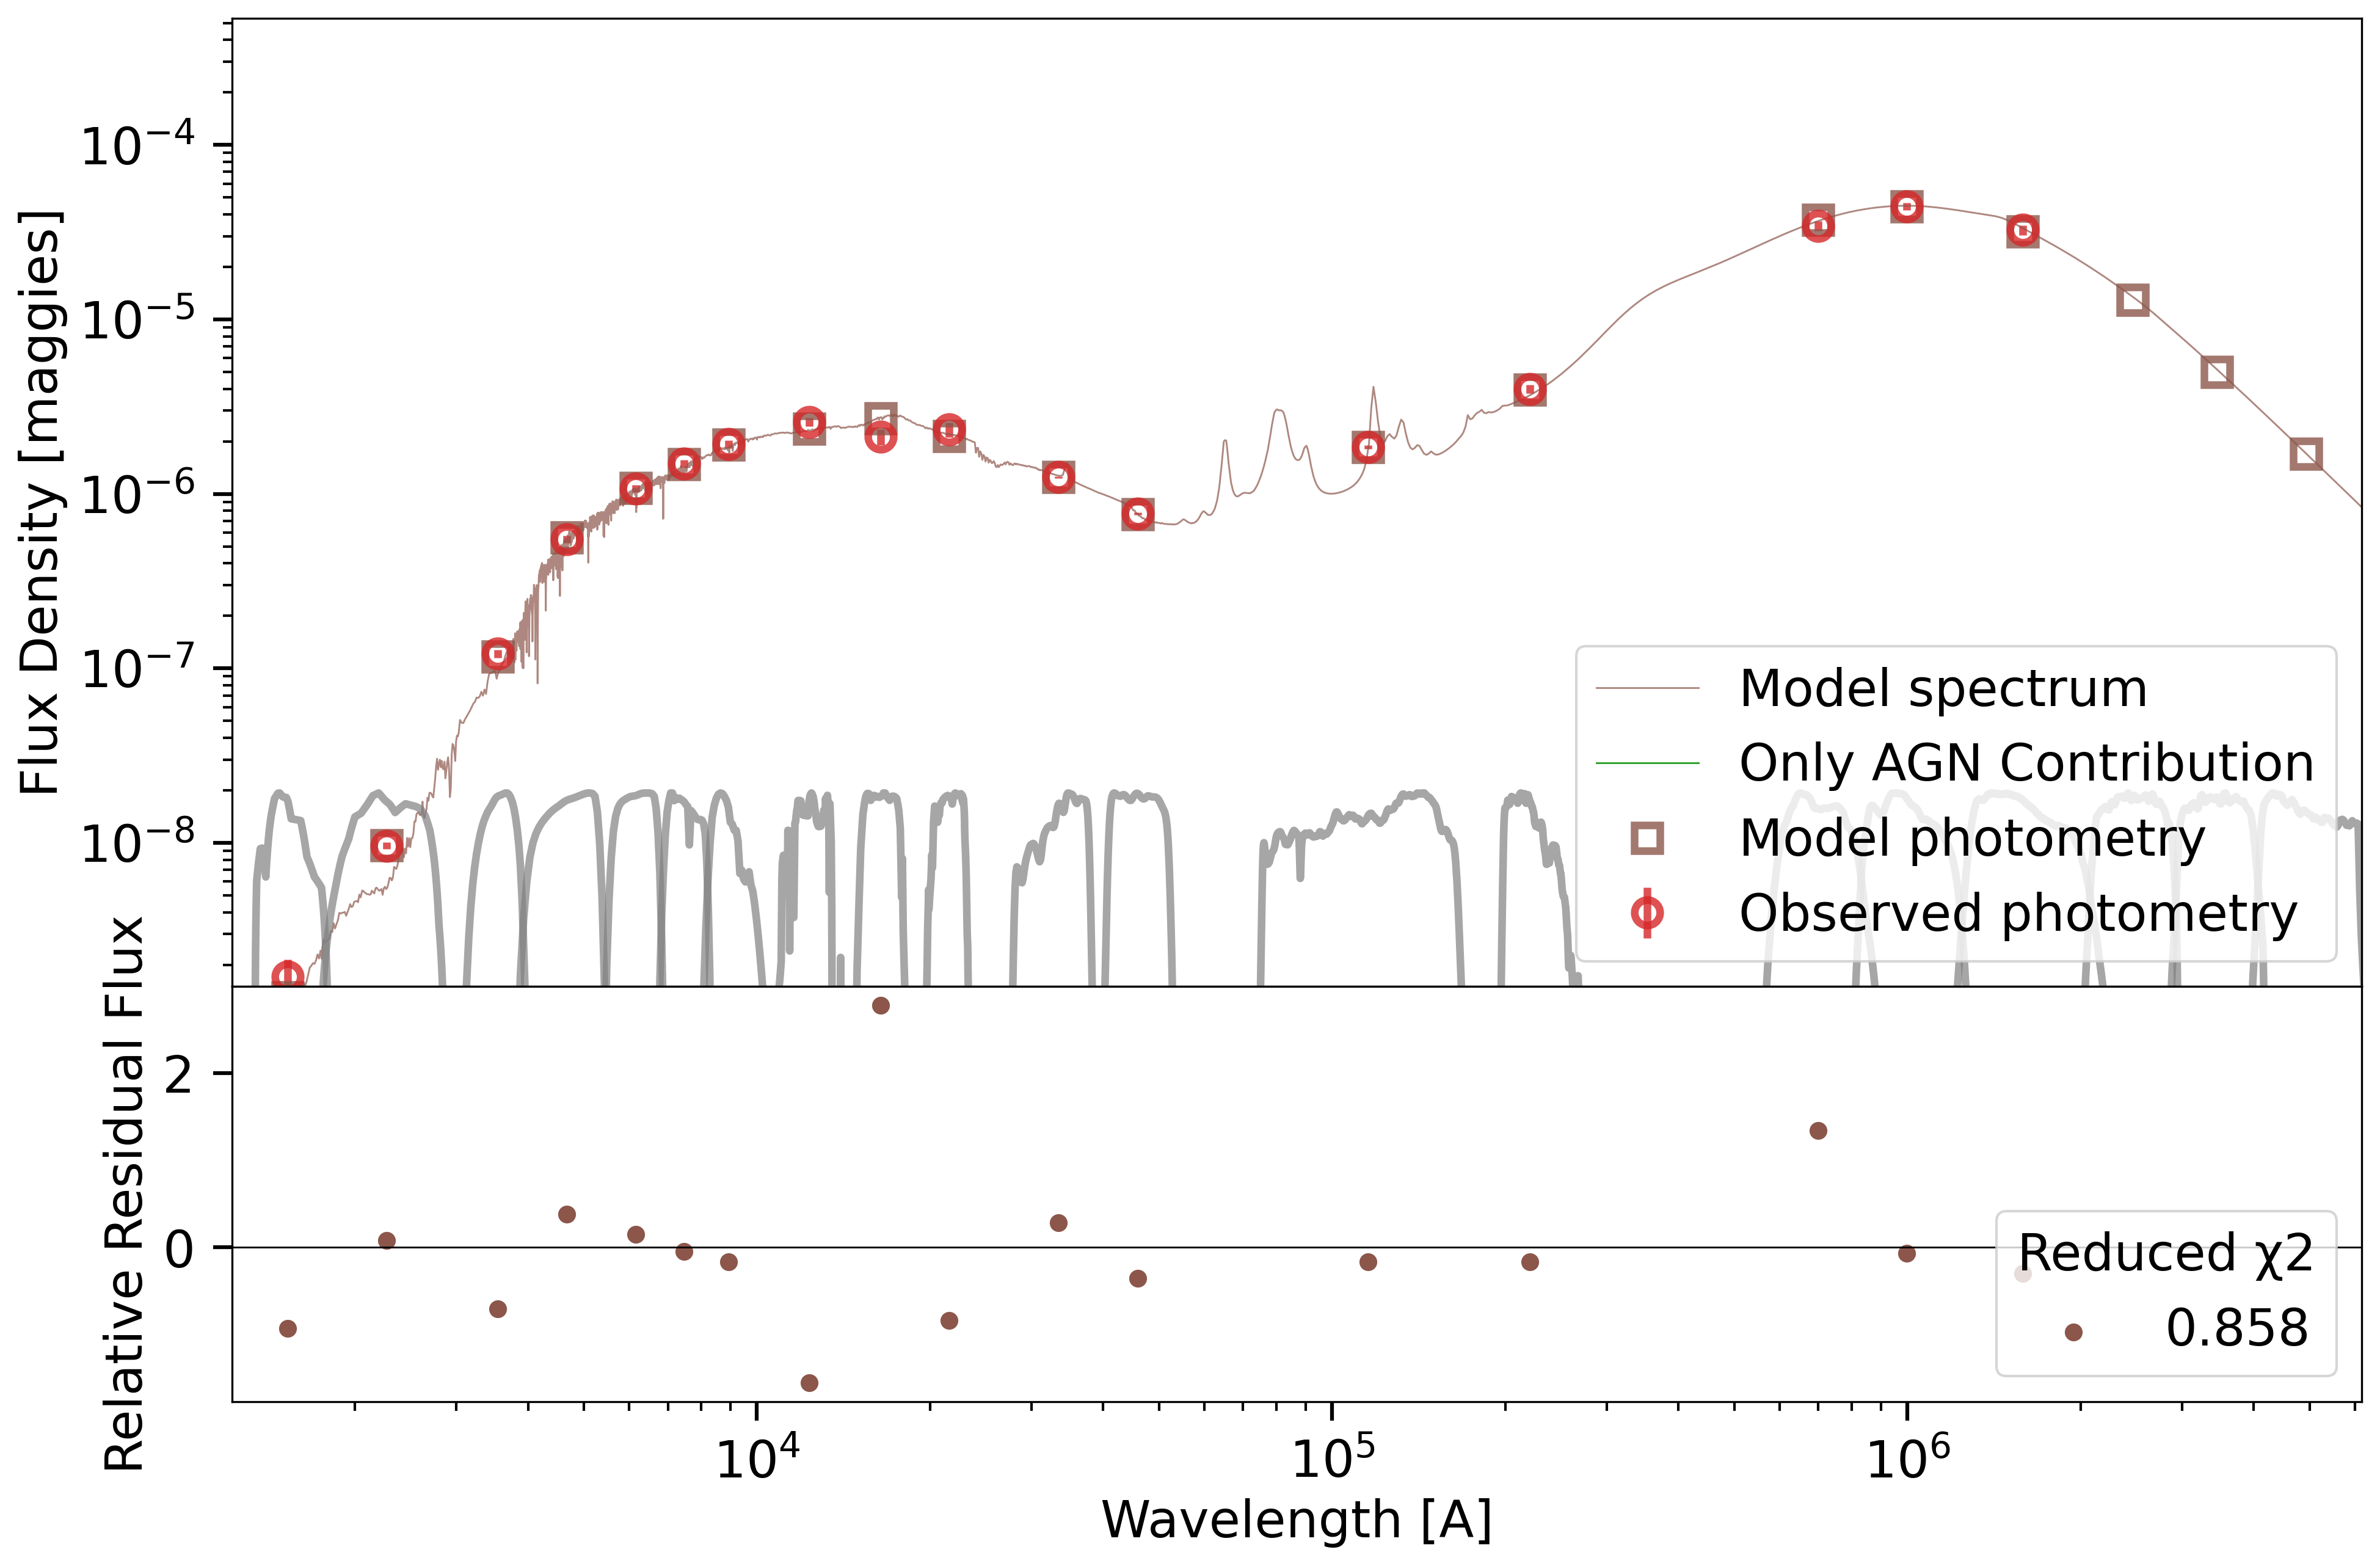

In [ ]:
### Plot SED and Residuals for specific galaxy ###
rcParams['font.size'] = 20
ymin = 1.5 * (10**-9) #* (1/10000)
ymax = 0.0005315684384467088 #* 2.7
xmin = 1222.447801222852 
xmax = 6164346.25 

# Make plot of data and model
fig1 = figure(figsize=(15,10), dpi=300)
ax = [0,0]
grid = GridSpec(10, 1, hspace=0)
ax[0] = subplot(grid[:7, :1])
ax[1] = subplot(grid[7:, :1])

print('Specific_galaxy_index', Specific_galaxy_index)

# for i in range(0, len(Specific_galaxy_index)):
# for i in range(0, len(Specific_galaxy_index)):
#     # specific_theta_bestfit = all_results[Specific_galaxy_index[i]]['bestfit']['parameter']
#     if i != np.max(Specific_galaxy_index):
#         # Do nothing
#         try_var = 0
#     else:
ax[0].loglog(wspec * zred_a[Specific_galaxy_index], mspec_map, 
    label='Model spectrum',lw=0.7,  alpha=0.7, color = my_cmap[5]) 
        
ax[0].errorbar(wphot, mphot_map, 
    label='Model photometry', marker='s', markersize=10, alpha=0.8, 
    ls='', lw=3,  markerfacecolor='none', color = my_cmap[5], markeredgewidth=3) 
        
### AGN Emission Contribution ###
mspec_agn = mspec_map - mspec_agn_inv
ax[0].loglog(wspec * zred_a[Specific_galaxy_index], mspec_agn, label='Only AGN Contribution', color = my_cmap[2]) #, color='orange'

### No AGN Contribution ###
# ax[0].loglog(wspec[Specific_galaxy_index[i]] * zred_a[Specific_galaxy_index[i]], mspec_agn_inv[Specific_galaxy_index[i]], label='No AGN Contribution', color = my_cmap[2])  #, color='purple'

ax[1].scatter(np.ma.masked_array(wphot, mask=χ_array_mask).compressed(),  
    χ_array[np.invert(χ_array_mask)[0]], color=my_cmap[5], label='{:.3f}'.format(χ2/χ2_DOF))
ax[1].plot(np.logspace(np.log10(wphot.min()) * 0.8, 
    np.log10(wphot.max()) * 1.2, len(wphot)), 
    np.zeros(len(wphot)), 'k-') 

# Plot observed data
ax[0].errorbar(wphot, G_obs['maggies'], 
    yerr=G_obs['maggies_unc'], label='Observed photometry', 
    ecolor= my_cmap[3], marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
    markerfacecolor='none', markeredgecolor=my_cmap[3], markeredgewidth=3)


# Plot transmission curves
for f in G_obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    ax[0].loglog(w, t, lw=3, color='gray', alpha=0.7)


ax[0].set_ylabel('Flux Density [maggies]')
ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([ymin, ymax])
ax[0].legend(loc=4)

ax[1].set_xscale('log')
ax[1].set_ylabel('Relative Residual Flux')
ax[1].set_xlabel('Wavelength [A]')

ax[1].set_xlim([xmin, xmax])
ax[1].legend(title='Reduced χ2', loc=4)

fig1.subplots_adjust(hspace=0)   

savefig('{0}SED_G{1}_{2}.png'.format(Galaxy_Path, all_results[Specific_galaxy_index]['run_params']['galaxy_num'], all_results[Specific_galaxy_index]['run_params']['gal_desig']))

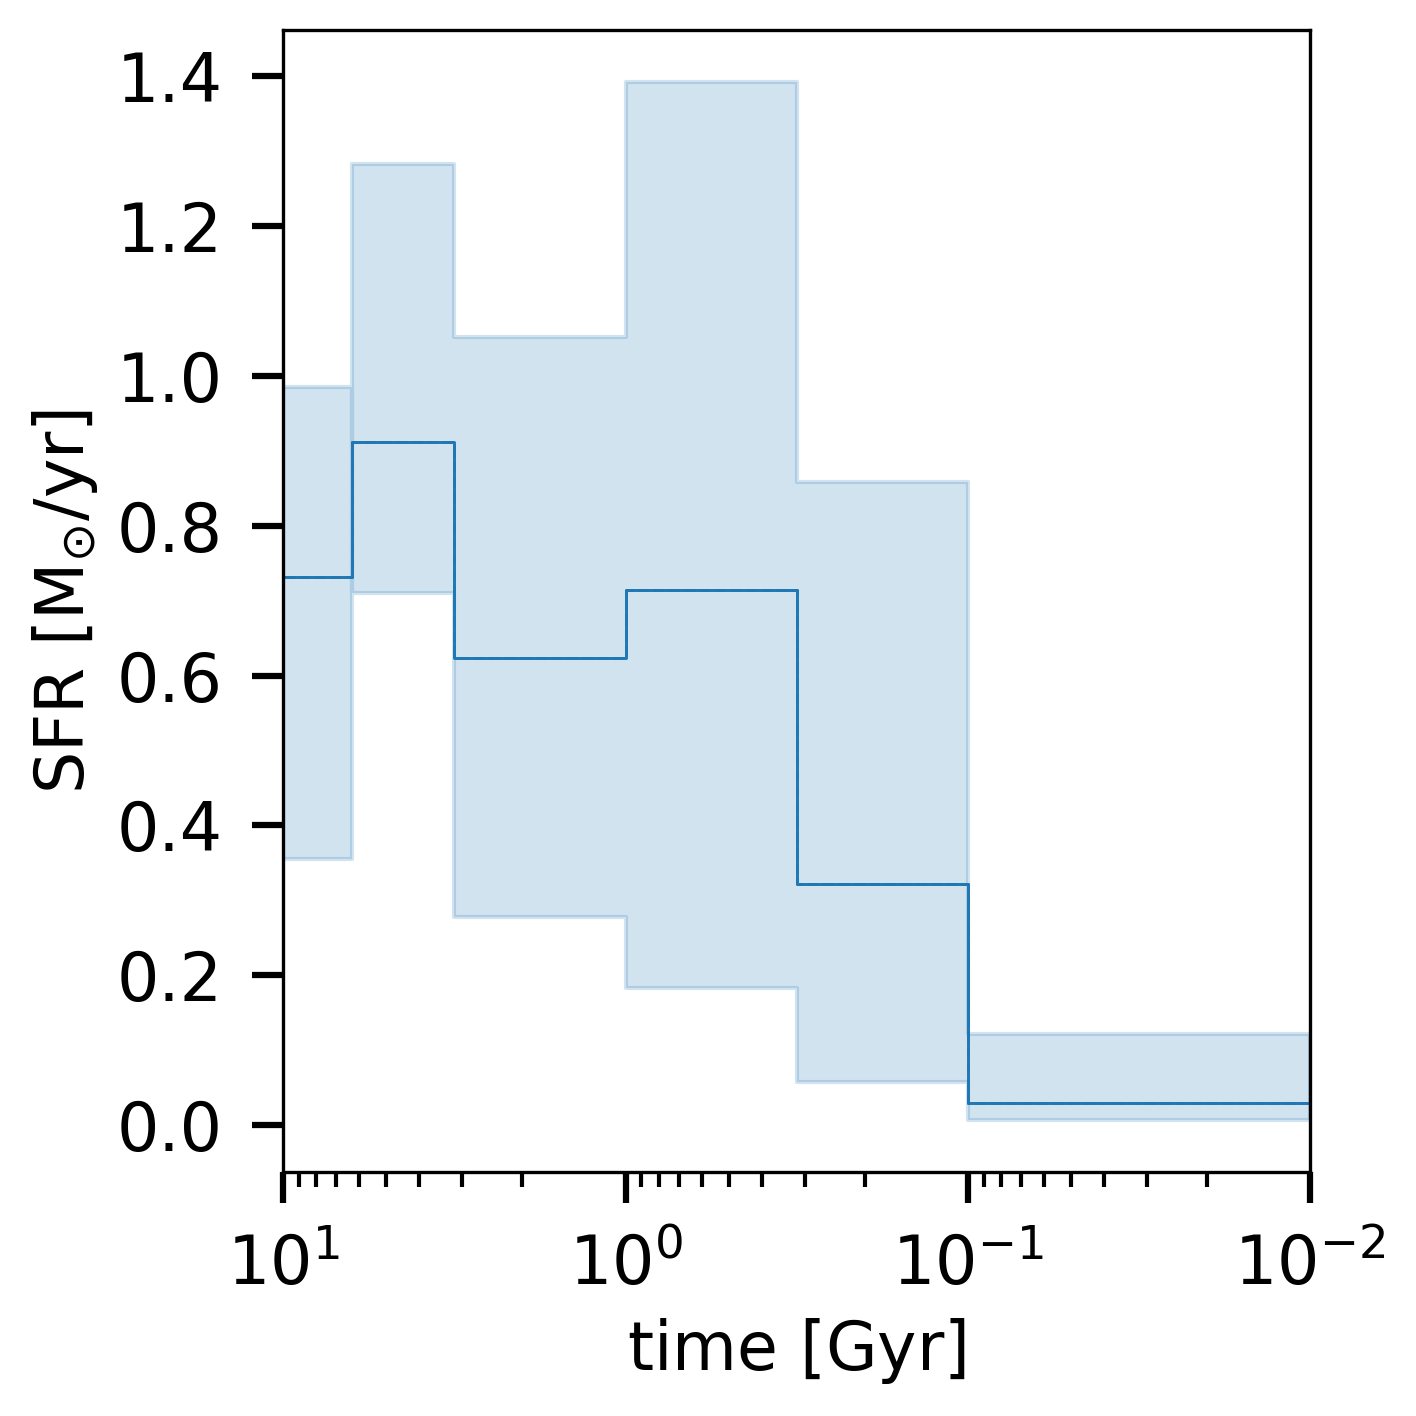

In [ ]:
### See SFR plot for specific galaxy ###
rcParams['font.size'] = 16
fig = figure(figsize=(5, 5), dpi = 300) #, dpi = 250)
ax=fig.add_subplot(1,1,1)

# Initialize the lists 
# age_GYR = [None] * len(Specific_galaxy_index)
# sfh_agebins = [None] * len(Specific_galaxy_index)
# total_mass_q50 = [None] * len(Specific_galaxy_index)
# total_mass_bestfit = [None] * len(Specific_galaxy_index)
# sfr1_q = [None] * len(Specific_galaxy_index)
# sfr_upper_q1 = [None] * len(Specific_galaxy_index)
# sfr_lower_q1 = [None] * len(Specific_galaxy_index)
# sfr1_bestfit = [None] * len(Specific_galaxy_index)

# Iterate through the runs for specific galaxy and plot SFR
# for i in range(0, len(Specific_galaxy_index)):
chain_shape = all_results[Specific_galaxy_index]['chain'].shape

if all_results[Specific_galaxy_index]['chain'].ndim > 2:
    flatchain = all_results[Specific_galaxy_index]['chain'].reshape(chain_shape[0] * chain_shape[1], chain_shape[2])

# Convert agelims to GYR and make first element nonzero
age_GYR = np.power(10, all_results[Specific_galaxy_index]['run_params']['agelims'])/1e9       # agebins in GYR
age_GYR[0] = 1e-2                                       # Make first element nonzero to avoid squishing plot

sfh_agebins = all_results[Specific_galaxy_index]['run_params']['agebins_init']
theta_labels = all_results[Specific_galaxy_index]['theta_labels']

# Pull out zfraction elements from theta_labels
zfrac_list = np.array([])
for label in range(0, len(theta_labels)):
    if theta_labels[label][:10] == 'z_fraction':
        zfrac_list = np.append(zfrac_list, label)

zfrac_list = zfrac_list.astype(int).tolist()
z_frac_num = np.array([theta_labels[k] for k in range (len (theta_labels)) if k in zfrac_list])

# Create a array of indicies from number of z_fractions
id_zfrac = np.nonzero(z_frac_num)[0]             

# Fill empty arrays with quantile values and bestfit theta
q_50 = np.empty(len(id_zfrac))
dx_up = np.empty(len(id_zfrac))
dx_down = np.empty(len(id_zfrac))
z_frac_bestfit = np.empty(len(id_zfrac))
for k in id_zfrac:
    q_50[k], dx_up[k], dx_down[k] = best_vals(flatchain.T[k+1])
    z_frac_bestfit[k] = theta_bestfit[Specific_galaxy_index][k+1]

# Define zfrac array and top and bottom limits
z_frac = q_50
z_frac_upper = q_50 + dx_up
z_frac_lower = q_50 - dx_down

# Find total mass for zfrac_to_sfr
total_mass_q50 = best_vals(flatchain.T[13])[0] 
total_mass_bestfit = theta_bestfit[Specific_galaxy_index][13] 

# Convert zfractions to sfr
sfr_quant = zfrac_to_sfr(total_mass_q50, z_frac, sfh_agebins)               # use logmass?
sfr_upper_quant = zfrac_to_sfr(total_mass_q50, z_frac_upper, sfh_agebins)
sfr_lower_quant = zfrac_to_sfr(total_mass_q50, z_frac_lower, sfh_agebins)
ssfr_quant = sfr_quant/total_mass_q50

sfr_bestfit = zfrac_to_sfr(total_mass_bestfit, z_frac, sfh_agebins)
ssfr_bestfit = sfr_bestfit/total_mass_bestfit

# Append last element to array to see full sfr in plot
sfr1_q = np.append(sfr_quant, sfr_quant[-1])                   
sfr_upper_q1 = np.append(sfr_upper_quant, sfr_upper_quant[-1])
sfr_lower_q1 = np.append(sfr_lower_quant, sfr_lower_quant[-1])
sfr1_bestfit = np.append(sfr_bestfit, sfr_bestfit[-1])

# Plot SFR in a step function and fill quantiles
step(age_GYR, sfr1_q, where='post', color=my_cmap[0], linestyle='-')
step(age_GYR, sfr1_bestfit, where='post', color=my_cmap[0], linestyle='--')
fill_between(age_GYR, sfr_lower_q1, sfr_upper_q1, color=my_cmap, alpha = 0.2, step='post')


xscale('log')
ylabel(r'$\rm{SFR\ [M_{\odot}/yr]}$', fontsize=16)
xlabel(r'$\rm{time\ [Gyr]}$', fontsize=16)
xlim(10, 1e-2)

# title('{0}_SFH_6'.format(all_results[Specific_galaxy]['run_params']))

tight_layout()

# savefig(Galaxy_Path + '{0}_SFH_6'.format(all_results[Specific_galaxy]['run_params']))
# Change to a comparison folder and save by specific galaxy
savefig('{0}SFH_G{1}_{2}.png'.format(Galaxy_Path, all_results[Specific_galaxy_index]['run_params']['galaxy_num'], all_results[Specific_galaxy_index]['run_params']['gal_desig']))

In [ ]:
### Table for specific Galaxy ###
pandas.options.display.float_format = "{:.2e}".format
df_1 = pandas.DataFrame(theta_bestfit[Specific_galaxy_index].T, columns=[ G_names[Specific_galaxy_index]],  index=all_results[0]['theta_labels'])
df_1.to_csv('{0}G{1}_{2}_theta_bestfit.csv'.format(Galaxy_Path, all_results[Specific_galaxy_index]['run_params']['galaxy_num'], all_results[Specific_galaxy_index]['run_params']['gal_desig']))
df_1

G28
logmass         1.03e+01
z_fraction_1    9.77e-01
z_fraction_2    9.50e-01
z_fraction_3    8.62e-01
z_fraction_4    6.94e-01
z_fraction_5    4.50e-01
dust2           2.88e-01
logzsol        -4.35e-01
dust_index     -1.20e+00
dust1_fraction  1.04e+00
duste_qpah      2.51e+00
duste_gamma     6.00e-02
duste_umin      1.12e+01
total_mass      1.00e+10
fagn            9.42e-03
agn_tau         5.91e+00
dust_ratio      1.11e+00

In [ ]:
theta_bestfit
# np.array([all_results[0]['theta_labels'], new_labels])

[array([ 1.06522549e+01,  9.35390717e-01,  2.49331348e-01,  9.36284313e-01,
         7.00566599e-01,  6.85852873e-01,  1.01209879e+00, -1.41789704e+00,
         4.91874371e-01,  1.22703413e+00,  3.18335345e-01,  7.99818360e-02,
         1.11335553e+01,  1.00000000e+10,  3.54696668e-03,  5.82400530e+00,
         1.31784933e+00]),
 array([ 1.09820673e+01,  8.25302912e-01,  8.77897299e-01,  7.87810069e-01,
         5.43777037e-01,  4.46506234e-01,  1.37124783e+00, -1.91109802e+00,
         2.37695493e-01,  5.62055884e-01,  9.88809431e-02,  3.42568543e-02,
         1.72856413e+01,  1.00000000e+10,  3.57044762e-03,  8.00643388e+00,
         8.21653317e-01]),
 array([ 9.58259802e+00,  6.74391305e-01,  5.70586185e-01,  5.98083373e-01,
         5.59867482e-01,  3.87050170e-01,  6.30026651e-01, -1.87270531e+00,
        -1.93178445e+00,  1.02017901e+00,  2.25962789e-01,  2.07192247e-04,
         2.49330206e+01,  1.00000000e+10,  1.28688307e-01,  1.99303237e+01,
         8.99214945e-01]),
 array(

In [ ]:
new_labels = ['G_numbers', 'Gal_desig', 'RA_array', 'DEC_array', 'zred_a', 'Gal_logmass']
new_arrays = [np.array(theta_bestfit).T, G_numbers, Gal_desig, RA_array, DEC_array, zred_a, Gal_logmass]


# A = np.vstack((theta_bestfit, Gal_desig))
A = zip(np.array(theta_bestfit).T, G_numbers, Gal_desig, RA_array, DEC_array, zred_a, Gal_logmass)
labels_zip = np.hstack((all_results[0]['theta_labels'], new_labels))
labels_zip

array(['logmass', 'z_fraction_1', 'z_fraction_2', 'z_fraction_3',
       'z_fraction_4', 'z_fraction_5', 'dust2', 'logzsol', 'dust_index',
       'dust1_fraction', 'duste_qpah', 'duste_gamma', 'duste_umin',
       'total_mass', 'fagn', 'agn_tau', 'dust_ratio', 'G_numbers',
       'Gal_desig', 'RA_array', 'DEC_array', 'zred_a', 'Gal_logmass'],
      dtype='<U14')

In [ ]:
# A_df = pandas.DataFrame(A, labels_zip)
print(np.shape(np.array(theta_bestfit)))
print(np.shape(np.array(G_numbers)))

vstack_array = 0
for item, i in enumerate(new_arrays):
    print(item)
    if item ==0:
        vstack_array = new_arrays[0]
    else:
        vstack_array = np.vstack((vstack_array, [new_arrays[item]]))

vstack_array = np.array(vstack_array)
labels_zip = np.array(labels_zip)
# hstack_array = np.vstack((np.array(theta_bestfit).T, new_arrays[1]))
# hstack_array = np.vstack((hstack_array, new_arrays[1])))
print(np.shape(vstack_array), np.shape(labels_zip))

(56, 17)
(56,)
0
1
2
3
4
5
6
(23, 56) (23,)


In [ ]:
A_df = pandas.DataFrame(vstack_array.T, columns=labels_zip)
A_df
A_df.to_csv(r'theta_G_num_Gal_desig_RA_DEC_z_LogM.csv')


In [ ]:
### Table of all runs for all galaxies with data ###
pandas.options.display.float_format = "{:.2e}".format
df = pandas.DataFrame(A_df, columns=labels_zip)
# df.to_csv(r'theta_bestfit_CSV.csv')
df
# Fagn ~ 0 when < 0.05

logmass  z_fraction_1  z_fraction_2  z_fraction_3  \
logmass             nan           nan           nan           nan   
z_fraction_1        nan           nan           nan           nan   
z_fraction_2        nan           nan           nan           nan   
z_fraction_3        nan           nan           nan           nan   
z_fraction_4        nan           nan           nan           nan   
z_fraction_5        nan           nan           nan           nan   
dust2               nan           nan           nan           nan   
logzsol             nan           nan           nan           nan   
dust_index          nan           nan           nan           nan   
dust1_fraction      nan           nan           nan           nan   
duste_qpah          nan           nan           nan           nan   
duste_gamma         nan           nan           nan           nan   
duste_umin          nan           nan           nan           nan   
total_mass          nan           nan           nan           nan   
fagn                nan           nan           nan           nan   
agn_tau             nan           nan           nan           nan   
dust_ratio          nan           nan           nan           nan   
G_numbers           nan           nan           nan           nan   
Gal_desig           nan           nan           nan           nan   
RA_array            nan           nan           nan           nan   
DEC_array           nan           nan           nan           nan   
zred_a              nan           nan           nan           nan   
Gal_logmass         nan           nan           nan           nan   

                z_fraction_4  z_fraction_5  dust2  logzsol  dust_index  \
logmass                  nan           nan    nan      nan         nan   
z_fraction_1             nan           nan    nan      nan         nan   
z_fraction_2             nan           nan    nan      nan         nan   
z_fraction_3             nan           nan    nan      nan         nan   
z_fraction_4             nan           nan    nan      nan         nan   
z_fraction_5             nan           nan    nan      nan         nan   
dust2                    nan           nan    nan      nan         nan   
logzsol                  nan           nan    nan      nan         nan   
dust_index               nan           nan    nan      nan         nan   
dust1_fraction           nan           nan    nan      nan         nan   
duste_qpah               nan           nan    nan      nan         nan   
duste_gamma              nan           nan    nan      nan         nan   
duste_umin               nan           nan    nan      nan         nan   
total_mass               nan           nan    nan      nan         nan   
fagn                     nan           nan    nan      nan         nan   
agn_tau                  nan           nan    nan      nan         nan   
dust_ratio               nan           nan    nan      nan         nan   
G_numbers                nan           nan    nan      nan         nan   
Gal_desig                nan           nan    nan      nan         nan   
RA_array                 nan           nan    nan      nan         nan   
DEC_array                nan           nan    nan      nan         nan   
zred_a                   nan           nan    nan      nan         nan   
Gal_logmass              nan           nan    nan      nan         nan   

                dust1_fraction  ...  total_mass  fagn  agn_tau  dust_ratio  \
logmass                    nan  ...         nan   nan      nan         nan   
z_fraction_1               nan  ...         nan   nan      nan         nan   
z_fraction_2               nan  ...         nan   nan      nan         nan   
z_fraction_3               nan  ...         nan   nan      nan         nan   
z_fraction_4               nan  ...         nan   nan      nan         nan   
z_fraction_5               nan  ...         nan   nan      nan         nan   
dust2                      nan  ... 

In [ ]:
### Table of all runs for all galaxies with data ###
pandas.options.display.float_format = "{:.2e}".format
df = pandas.DataFrame(theta_bestfit, index=[G_names], columns=all_results[0]['theta_labels']).T
# df.to_csv(r'theta_bestfit_CSV.csv')
df
# Fagn ~ 0 when < 0.05

G0        G1       G10       G11       G12       G13  \
logmass         1.07e+01  1.10e+01  9.58e+00  1.04e+01  1.05e+01  1.02e+01   
z_fraction_1    9.35e-01  8.25e-01  6.74e-01  8.96e-01  9.76e-01  8.65e-01   
z_fraction_2    2.49e-01  8.78e-01  5.71e-01  7.15e-01  9.98e-01  4.05e-01   
z_fraction_3    9.36e-01  7.88e-01  5.98e-01  6.60e-01  8.41e-01  6.80e-01   
z_fraction_4    7.01e-01  5.44e-01  5.60e-01  4.06e-01  5.78e-01  3.76e-01   
z_fraction_5    6.86e-01  4.47e-01  3.87e-01  6.11e-01  1.60e-01  3.09e-01   
dust2           1.01e+00  1.37e+00  6.30e-01  1.46e+00  3.17e-01  1.25e+00   
logzsol        -1.42e+00 -1.91e+00 -1.87e+00 -1.94e+00 -4.47e-01 -1.90e+00   
dust_index      4.92e-01  2.38e-01 -1.93e+00 -5.15e-01 -8.52e-01 -4.09e-01   
dust1_fraction  1.23e+00  5.62e-01  1.02e+00  1.44e+00  8.45e-01  1.13e+00   
duste_qpah      3.18e-01  9.89e-02  2.26e-01  3.37e-01  2.62e+00  3.72e-01   
duste_gamma     8.00e-02  3.43e-02  2.07e-04  8.27e-05  2.46e-02  1.03e-04   
duste_umin      1.11e+01  1.73e+01  2.49e+01  1.26e+01  2.30e+01  1.48e+01   
total_mass      1.00e+10  1.00e+10  1.00e+10  1.00e+10  1.00e+10  1.00e+10   
fagn            3.55e-03  3.57e-03  1.29e-01  4.85e-04  1.66e-03  3.44e-04   
agn_tau         5.82e+00  8.01e+00  1.99e+01  7.18e+00  6.44e+00  5.55e+00   
dust_ratio      1.32e+00  8.22e-01  8.99e-01  1.08e+00  9.20e-01  6.59e-01   

                     G14       G15       G16       G17  ...       G52  \
logmass         1.06e+01  1.10e+01  1.04e+01  1.05e+01  ...  1.12e+01   
z_fraction_1    9.93e-01  9.94e-01  9.02e-01  9.76e-01  ...  9.79e-01   
z_fraction_2    9.94e-01  9.10e-01  6.46e-01  9.67e-01  ...  9.20e-01   
z_fraction_3    5.68e-01  6.69e-01  3.46e-01  6.93e-01  ...  9.86e-01   
z_fraction_4    2.66e-01  6.86e-01  5.65e-01  7.79e-01  ...  8.63e-01   
z_fraction_5    7.66e-02  6.92e-01  2.00e-01  8.63e-01  ...  7.92e-01   
dust2           2.42e-01  5.29e-02  1.15e+00  2.92e-01  ...  1.83e-01   
logzsol         1.76e-01  3.93e-02 -1.38e+00 -2.63e-01  ... -7.49e-01   
dust_index     -1.97e+00 -1.26e+00 -6.01e-01 -1.05e+00  ... -5.99e-01   
dust1_fraction  1.06e+00  7.28e-01  9.13e-01  1.06e+00  ...  8.68e-01   
duste_qpah      2.56e+00  1.60e+00  6.42e-02  2.63e+00  ...  3.99e+00   
duste_gamma     5.62e-02  1.46e-01  1.91e-05  7.74e-02  ...  1.79e-03   
duste_umin      6.44e+00  1.53e+00  5.05e+00  4.94e+00  ...  2.93e+00   
total_mass      1.00e+10  1.00e+10  1.00e+10  1.00e+10  ...  1.00e+10   
fagn            2.26e-02  3.82e-04  4.05e-04  3.65e-04  ...  7.50e-04   
agn_tau         8.04e+00  7.14e+00  3.42e+01  1.52e+01  ...  4.12e+01   
dust_ratio      1.07e+00  9.89e-01  1.31e+00  1.02e+00  ...  1.13e+00   

                     G53       G54       G55       G56       G57        G6  \
logmass         1.04e+01  1.09e+01  1.09e+01  1.02e+01  1.07e+01  1.03e+01   
z_fraction_1    9.99e-01  7.46e-01  8.72e-01  9.55e-01  9.89e-01  7.87e-01   
z_fraction_2    8.06e-01  7.72e-01  9.96e-01  9.41e-01  9.77e-01  9.86e-01   
z_fraction_3    9.28e-01  9.55e-01  9.97e-01  8.36e-01  9.45e-01  8.39e-01   
z_fraction_4    8.27e-01  9.96e-01  9.60e-01  6.58e-01  6.73e-01  7.55e-01   
z_fraction_5    9.01e-01  8.19e-01  8.70e-01  4.18e-01  1.85e-01  1.67e-01   
dust2           6.47e-01  8.85e-01  6.48e-01  4.42e-01  2.10e-01  2.78e-01   
logzsol        -1.57e+00 -5.06e-01 -1.24e+00 -7.22e-01 -6.23e-01 -2.31e-01   
dust_index     -6.64e-01 -4.62e-01 -1.20e-02 -6.12e-01 -6.51e-01 -1.00e+00   
dust1_fraction  1.05e+00  1.28e+00  1.21e+00  1.12e+00  1.23e+00  1.06e+00   
duste_qpah      6.36e-01  2.98e-01  2.09e+00  1.45e-01  1.16e+00  2.54e+00   
duste_gamma     7.22e-04  3.72e-04  1.06e-02  1.47e-01  2.34e-01  4.84e-02   
duste_umin      8.27e+00  1.19e+01  2.91e+00  1.33e-01  1.73e-01  6.59e+00   
total_mass      1.00e+10  1.00e+10  1.00e+10  1.00e+10  1.00e+10  1.00e+10   
fagn            3.96e-04  3.72e-04  4.89e-02  3.47e-02  3.27e-04  4.00e-04   
agn_tau         2.22e+01  1.16e+01  9.39e+00  6.49e+00

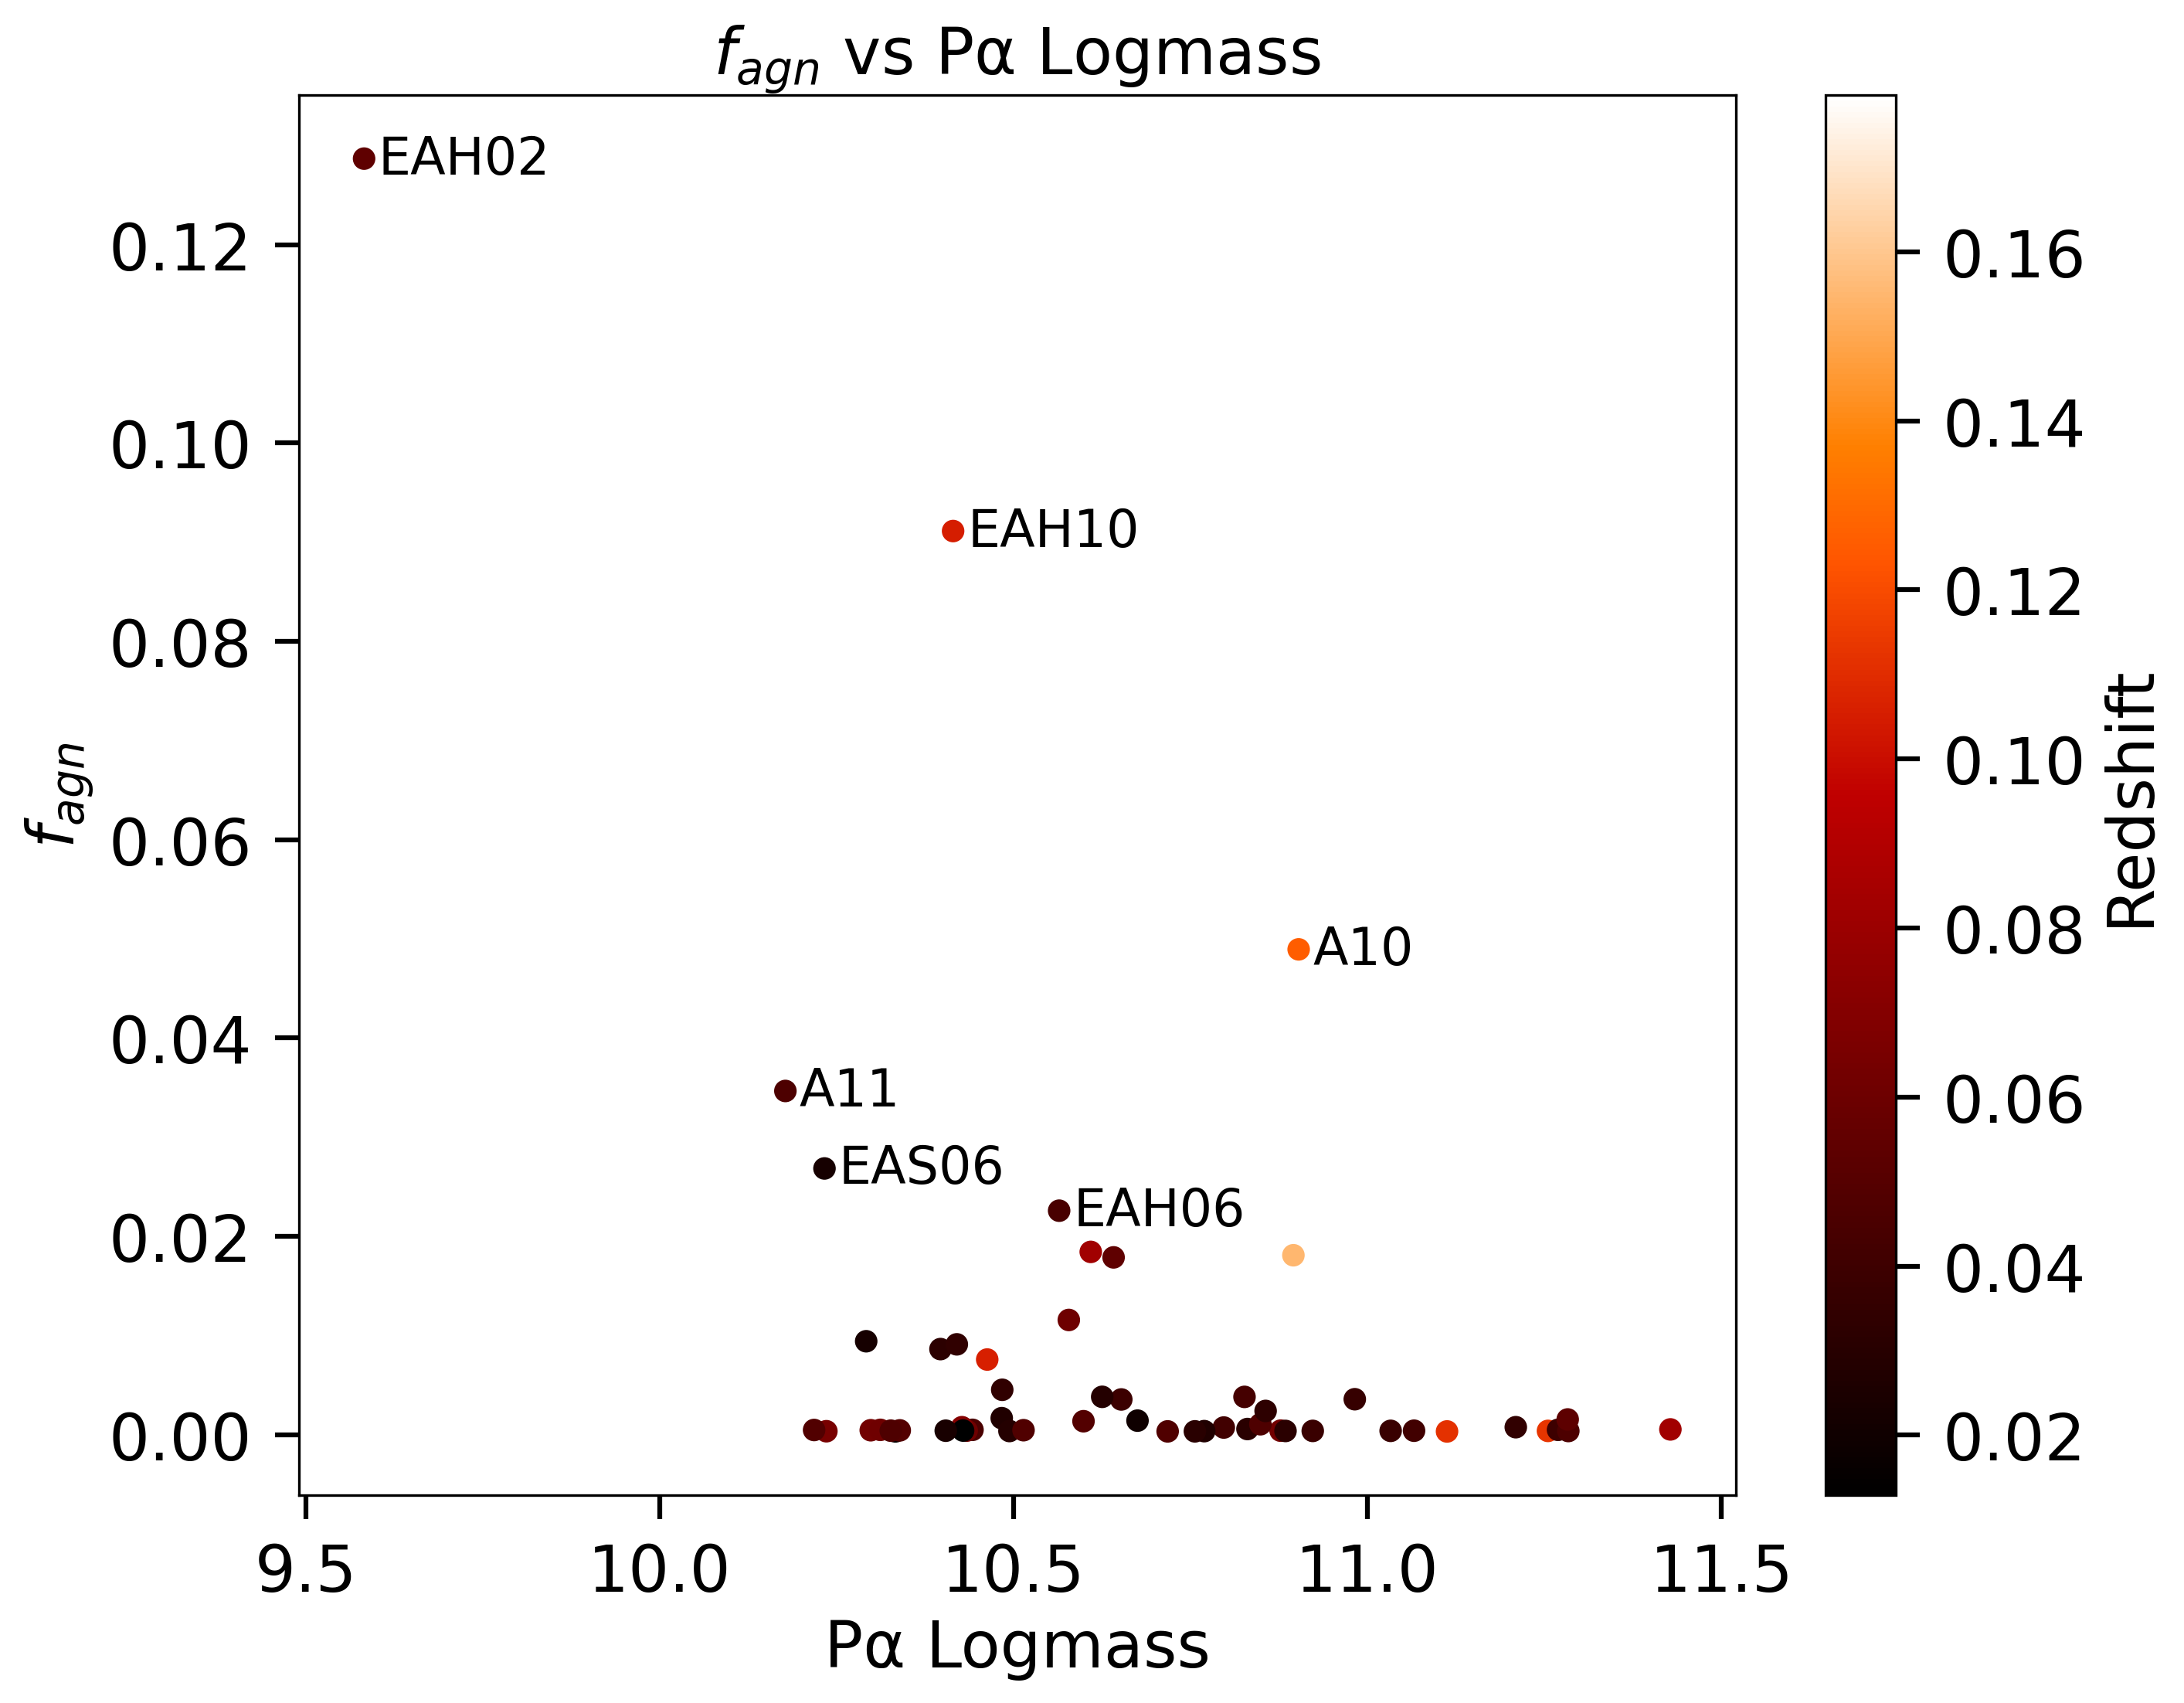

In [ ]:
### Plot Simulated f_AGN Values vs Simulated Logmass ###
rcParams['font.size'] = 20

redshift = [item -1 for item in zred_a]
# redshift_size = [item*1000 for item in redshift]

fig = figure(figsize=(10,8))
logmass = [lmass[0] for lmass in theta_bestfit]
fagn = [f_agn[14] for f_agn in theta_bestfit]

scatter(logmass, fagn, c=redshift, cmap='gist_heat') #s=

cbar = colorbar() #ticks = redshift
# cbar.set_ticklabels(['{0}, {1}'.format(G_numbers[i], Gal_desig[i]) for i in range(0, len(G_numbers))])
cbar.set_label(label='Redshift', size=font_size)

xlabel('Pα Logmass', size=font_size)
ylabel('$f_{agn}$', size= font_size)
title('$f_{agn}$ vs Pα Logmass', size=font_size)
offset = .000001

for i, txt in enumerate(Gal_desig): #G_numbers
    if fagn[i] >= .021:
        annotate(txt, (logmass[i] + 20000*offset, fagn[i] - 1500*offset), fontsize = 16)


savefig('Comparison/fagn_logmass_z.png')

In [ ]:
# print(Cas_GSI_data_masked['h_alpha_flux_err'])
# print(Cas_GSI_data_masked['H_ALPHA_FLUX'])

H_alpha_mask = (Cas_GSI_data['H_ALPHA_FLUX']/Cas_GSI_data['h_alpha_flux_err'] >= 3) #np.where
H_beta_mask = (Cas_GSI_data['H_BETA_FLUX']/Cas_GSI_data['h_beta_flux_err'] >= 3)
Scipri_mask = (Cas_GSI_data['sciencePrimary'] == 1)

In [ ]:
Cas_GSI_data_masked = Cas_GSI_data[H_alpha_mask & H_beta_mask & Scipri_mask]
Cas_GSI_data_masked = Cas_GSI_data[Cas_GSI_data_masked['recno'] != 50]   # Get rid of 50 b/c not in G_numbers/data

IndexError: boolean index did not match indexed array along dimension 0; dimension is 63 but corresponding boolean dimension is 42

In [ ]:
# Remap SDSS query

sdss_fagn = []
sdss_gal_desig = []
sdss_G_numbers = []
sdss_G_index = []
for i in range(0, len(Cas_GSI_data_masked['recno'])):
    index = np.where(Cas_GSI_data_masked['recno'][i] -1 == G_numbers)
    G_index = np.where(G_numbers == Cas_GSI_data_masked['recno'][i] -1)
    # print(G_index[0])
    if len(G_index[0]) == 0:
        print(Cas_GSI_data_masked['recno'][i], 'is not in G_Numbers (',Cas_GSI_data_masked['recno'][i] -1 ,') at', i)
    elif len(index[0]) == 0:
        print(Cas_GSI_data_masked['recno'][i],':This galaxy is not in G_numbers array')     # G49 is not in G_numbers (also has 2 casjobs entries)
    else:
        # print(index)
        if len(G_index) > 1:
            print('There are', len(G_index), 'galaxies in Casjobs')   # All galaxies have 1 entry in casjobs
        # print(G_numbers[index[0][0]])
        sdss_fagn.append(fagn[G_index[0][0]])
        sdss_gal_desig.append(Gal_desig[G_index[0][0]])
        sdss_G_numbers.append(G_numbers[G_index[0][0]])               # Index of casjobs for where G_numbers are
        sdss_G_index.append(G_index[0][0])                          # Index of G_numbers where casjobs are

print(G_numbers[sdss_G_index[12]], Cas_GSI_data_masked['recno'][12] -1)
print(len(sdss_G_index), len(G_numbers), len(sdss_G_numbers))

# scatter(np.log10(xall), np.log10(yall), c=sdss_fagn)         # need to remove scipri = 0 for scipri_array

50 is not in G_Numbers ( 49 ) at 21
50 is not in G_Numbers ( 49 ) at 26
8 8
61 56 61


In [ ]:
# sdss_G_index

In [ ]:
res = np.empty(len(sdss_G_index), dtype=bool)
res_m = []
for i in sdss_G_index:
    if i not in res_m:
        res[i] = True
        res_m.append(i)
    else:
        res[i] = False

sdss_G_index_m = [b for a , b in zip(res, sdss_G_index) if a]
print(len(sdss_G_index_m))

sdss_G_numbers_m = [b for a , b in zip(res, sdss_G_numbers) if a]
sdss_gal_desig_m = [b for a , b in zip(res, sdss_gal_desig) if a]
print(sdss_G_index_m)
# Cas_GSI_data_masked_m = [b for a , b in zip(res, Cas_GSI_data_masked) if a]


sdss_fagn_m = [b for a , b in zip(res, sdss_fagn) if a]
# print(len(sdss_G_index_m), len(sdss_G_numbers_m), sdss_G_numbers_m[len(sdss_G_numbers_m -1)])
for i, iii in enumerate(sdss_G_index_m):
    # print(i)
    # ii = i -1
    # print(ii, G_numbers[sdss_G_index_m[ii]], sdss_fagn_m[ii] - fagn[sdss_G_index_m[ii]], 
    #         Gal_desig[sdss_G_index_m[ii]])
    # print(iii)
    print(i, iii, sdss_gal_desig_m[i], G_numbers[sdss_G_index_m[i]], Gal_desig[sdss_G_index_m[i]], 
        fagn[sdss_G_index_m[i]] - sdss_fagn_m[i])
print(max(sdss_fagn_m))

52
[7, 32, 51, 46, 11, 55, 50, 1, 50, 15, 26, 54, 49, 49, 23, 16, 35, 31, 12, 48, 19, 17, 43, 28, 41, 45, 18, 20, 36, 33, 6, 30, 29, 22, 0, 38, 47, 40, 8, 24, 44, 27, 2, 10, 5, 14, 21, 8, 21, 34, 25, 9]
0 7 EAH07 15 EAH07 0.0
1 32 EAS13 39 EAS13 0.0
2 51 A12 57 A12 0.0
3 46 A7 52 A7 0.0
4 11 EAH11 19 EAH11 0.0
5 55 EAH01 9 EAH01 0.0
6 50 A11 56 A11 0.0
7 1 R2 1 R2 0.0
8 50 A11 56 A11 0.0
9 15 EAH14 22 EAH14 0.0
10 26 EAS06 32 EAS06 0.0
11 54 R10 8 R10 0.0
12 49 A10 55 A10 0.0
13 49 A10 55 A10 0.0
14 23 R4 3 R4 0.0
15 16 EAH15 23 EAH15 0.0
16 35 EAS15 41 EAS15 0.0
17 31 EAS11 37 EAS11 0.0
18 12 R3 2 R3 0.0
19 48 A9 54 A9 0.0
20 19 EAH18 26 EAH18 0.0
21 17 EAH16 24 EAH16 0.0
22 43 R6 5 R6 0.0
23 28 EAS08 34 EAS08 0.0
24 41 A2 47 A2 0.0
25 45 A6 51 A6 0.0
26 18 EAH17 25 EAH17 0.0
27 20 EAS01 27 EAS01 0.0
28 36 F34 42 F34 0.0
29 33 R5 4 R5 0.0
30 6 EAH06 14 EAH06 0.0
31 30 EAS10 36 EAS10 0.0
32 29 EAS09 35 EAS09 0.0
33 22 EAS03 29 EAS03 0.0
34 0 R1 0 R1 0.0
35 38 F36 44 F36 0.0
36 47 A8 53

IndexError: index 46 is out of bounds for axis 0 with size 46

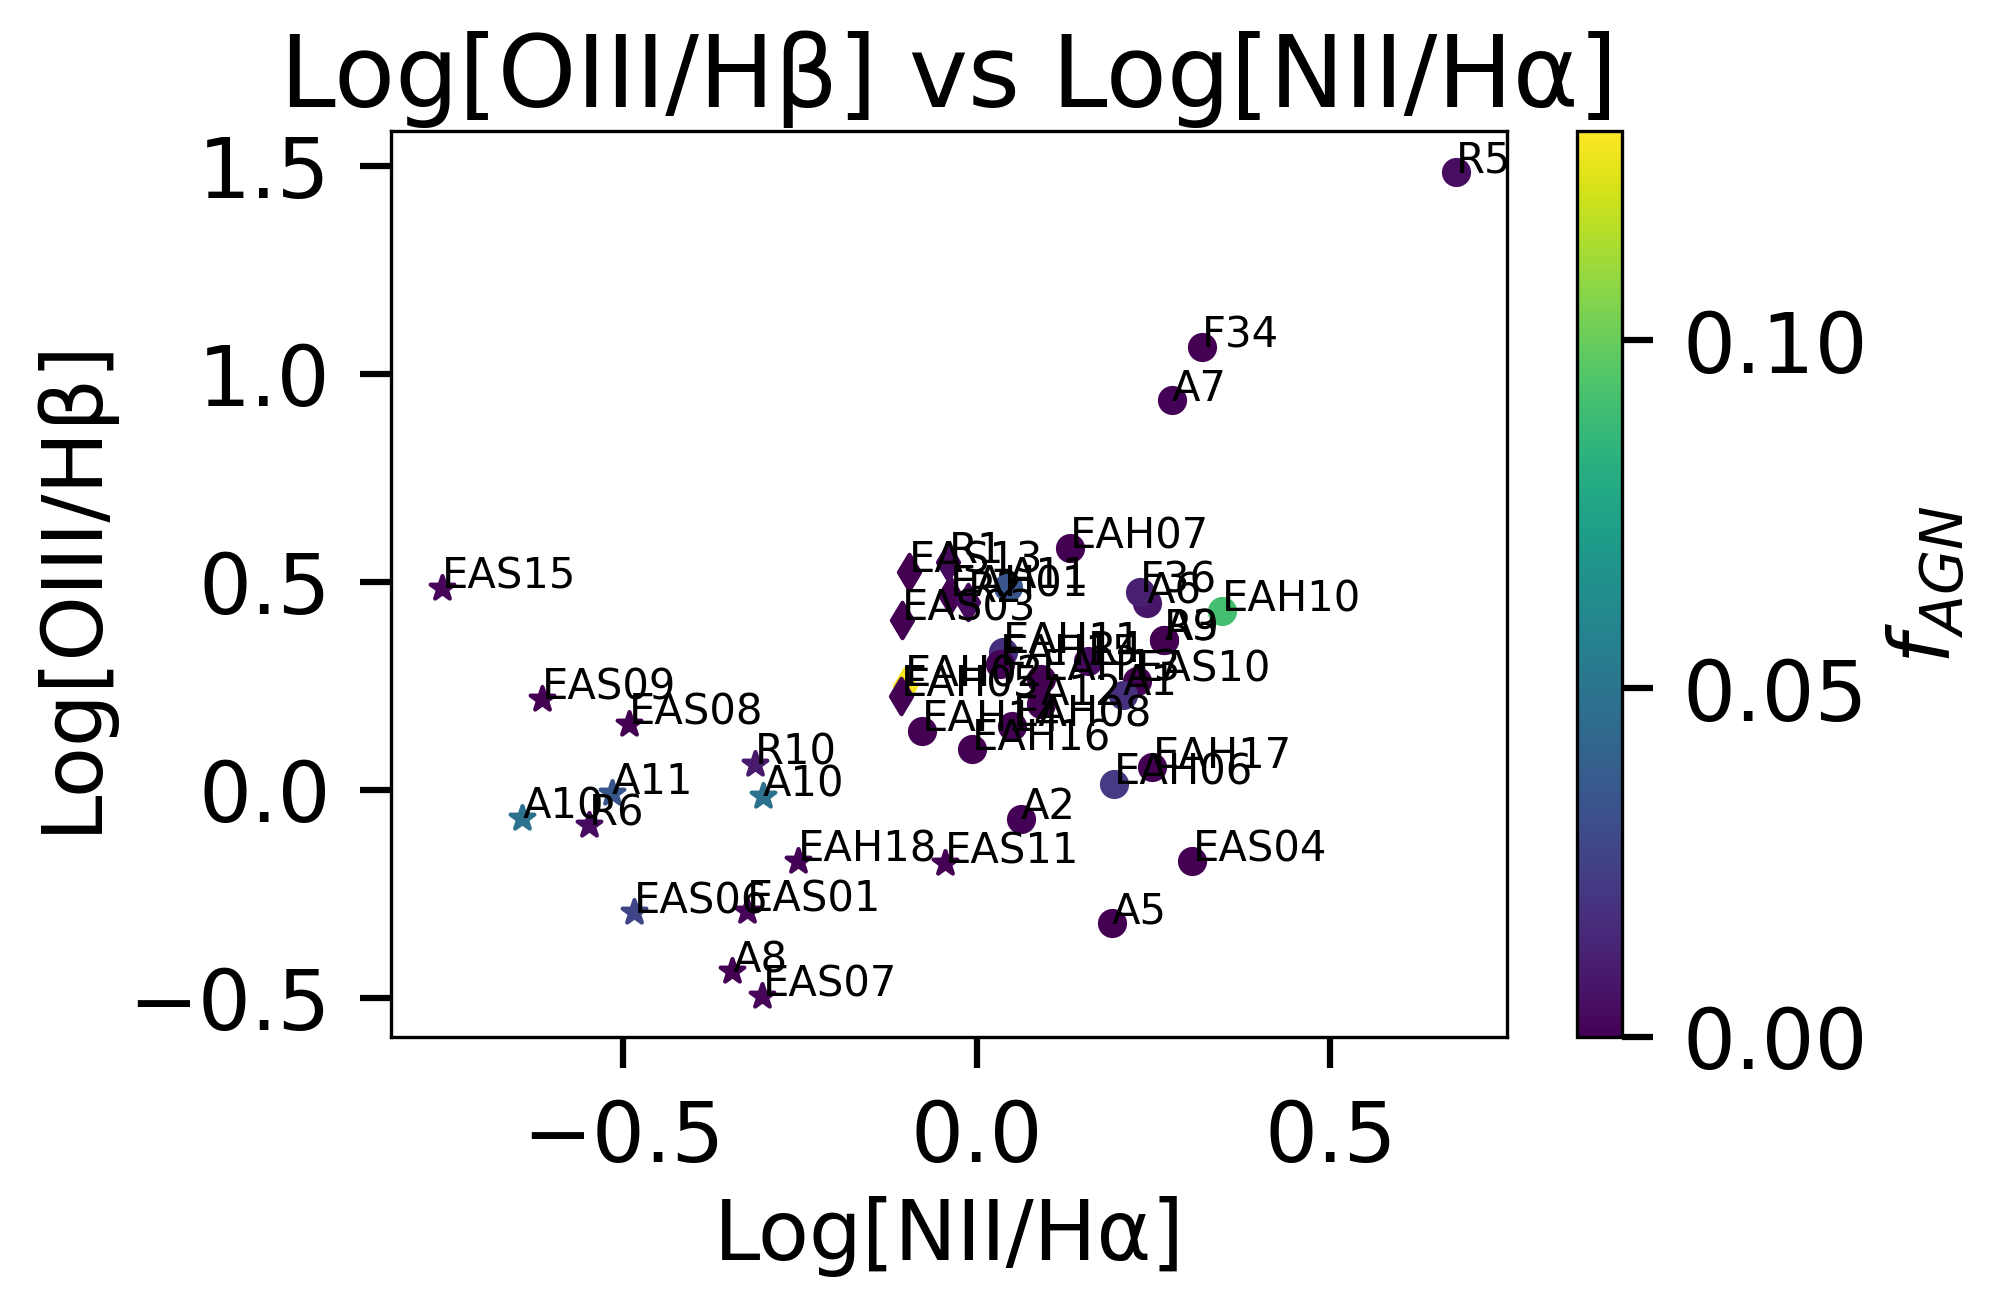

In [ ]:
from matplotlib import colors

xalli_u = np.divide(Cas_GSI_data_masked['NII_6584_FLUX'], Cas_GSI_data_masked['H_ALPHA_FLUX'], 
    out = np.zeros_like(Cas_GSI_data_masked['NII_6584_FLUX']), where=(Cas_GSI_data_masked['H_ALPHA_FLUX'] != 0))

yalli_u = np.divide(Cas_GSI_data_masked['OIII_5007_FLUX'], Cas_GSI_data_masked['H_BETA_FLUX'], 
    out = np.zeros_like(Cas_GSI_data_masked['OIII_5007_FLUX']), where=(Cas_GSI_data_masked['H_BETA_FLUX'] != 0))


xalli_um = np.array([b for a , b in zip(res, xalli_u) if a])
yalli_um = np.array([b for a , b in zip(res, yalli_u) if a])

usefulness2 = np.where((xalli_um > 0) & (yalli_um > 0) )

xall_um = xalli_um[usefulness2]
yall_um = yalli_um[usefulness2]

# print(len(xall_u), len(yall_u))

crit1 = np.log10(yall_um) - np.log10(xall_um) * np.tan((90 - 25) * np.pi/180)
crit2 = (np.log10(yall_um) - 1.19) * (np.log10(xall_um)-0.47)
n_seyferts = np.where((crit1 > .45) & (crit2 < 0.61))
n_sf = np.where(crit2 > 0.61)
n_liner = np.where((crit1 < 0.45) & (crit2 < 0.61))


# galaxy_type_array = np.empty(len(xall_u))
galaxy_marker_type = np.empty(len(xall_um), dtype=str)
for i in range(0, len(sdss_G_index_m)):
    if i in n_liner[0]:
        galaxy_marker_type[i] = "o"
    elif i in n_sf[0]:
        galaxy_marker_type[i] = '*'
    elif i in n_seyferts[0]:
        galaxy_marker_type[i] = 'd'

# cbar = colorbar(ticks = sdss_fagn)    
normalize = colors.Normalize(vmin=0, vmax=0.13)

for i in range(0, len(xall_um)):
    scatter(np.log10(xall_um[i]), np.log10(yall_um[i]), c=sdss_fagn_m[i], norm=normalize, marker = galaxy_marker_type[i])
cbar = colorbar()
cbar.set_label(label='$f_{AGN}$')

title('Log[OIII/Hβ] vs Log[NII/Hα]')
ylabel('Log[OIII/Hβ]')
xlabel('Log[NII/Hα]')

# sdss_gal_desig_u = sdss_gal_desig[usefulness2[0][0]]
for i in range(0, len(sdss_G_index_m)): #G_numbers
    # print(i)
    # if sdss_fagn_m[i] >= .021:
        annotate(sdss_gal_desig_m[i], (np.log10(xall_um[i]), np.log10(yall_um[i])), fontsize=10)



# print(i, iii, sdss_gal_desig_m[i], G_numbers[sdss_G_index_m[i]], Gal_desig[sdss_G_index_m[i]], 
#         fagn[sdss_G_index_m[i]] - sdss_fagn_m[i])

# print(sdss_gal_desig)

# for i in range(0, len(xall_u)):
#     if sdss_fagn[i] >= 0.021:
#         annotate(sdss_gal_desig[i], (np.log10(xall_u[i]), np.log10(yall_u[i])))

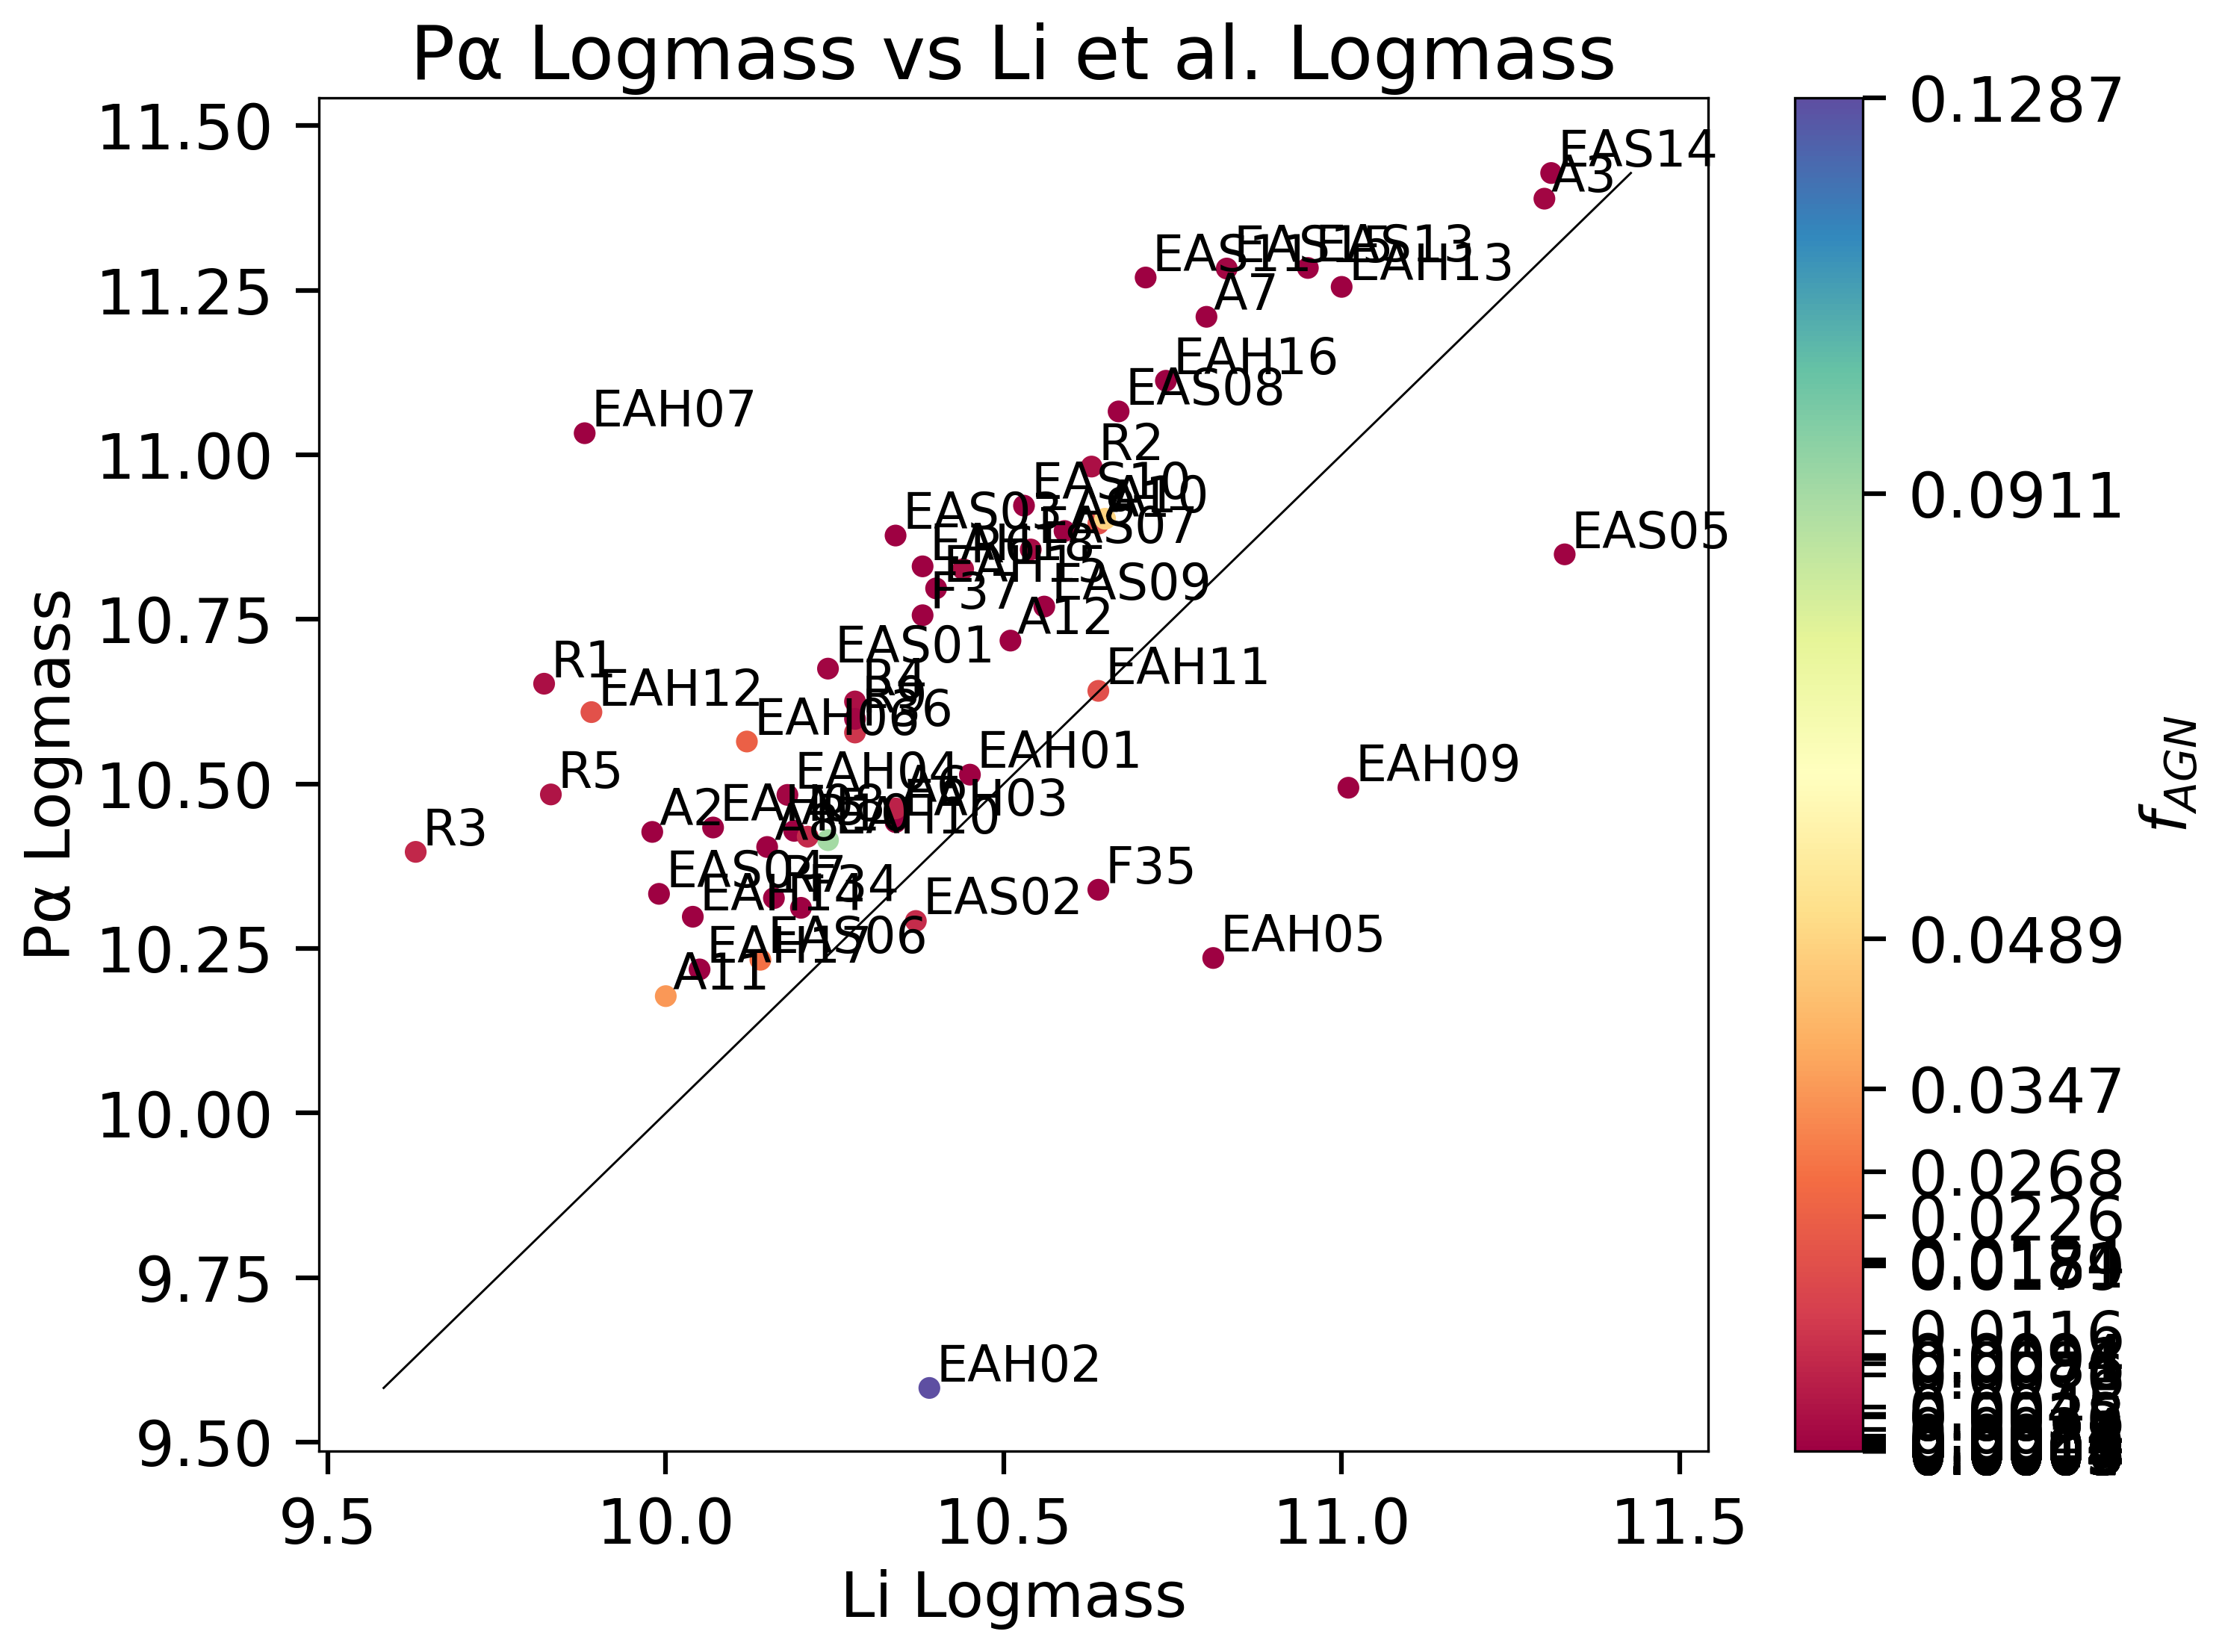

In [ ]:
### Plot Pα Simulated Logmass vs Li et al Logmass ### 
logmass_min = min(logmass + Gal_logmass)
logmass_max = max(logmass + Gal_logmass)
logmass_line_lin = np.linspace(logmass_min, logmass_max, num=100)

fig = figure(figsize=(10,8))
scatter(Gal_logmass, logmass, c=fagn, cmap='Spectral')
# scatter(Gal_logmass, logmass, c=G_numbers, cmap='Spectral')

plot(logmass_line_lin, logmass_line_lin, 'k')

cbar = colorbar(ticks = fagn)
# cbar = colorbar(ticks = G_numbers)

# cbar.set_ticklabels(['{0}, {1}'.format(G_numbers[i], Gal_desig[i]) for i in range(0, len(G_numbers))])
# cbar.set_label(label='Galaxy Number', size=16)
cbar.set_label(label='$f_{AGN}$')

title('Pα Logmass vs Li et al. Logmass')
ylabel('Pα Logmass')
xlabel('Li Logmass')
xlim(logmass_min * 0.99, logmass_max * 1.01)
ylim(logmass_min * 0.99, logmass_max * 1.01)

offset = .01
for i, txt in enumerate(G_numbers):
    # print(i)
    annotate(Gal_desig[i], (Gal_logmass[i] + offset, logmass[i] + offset), size = 16)        #str(txt) + ','+ 

# https://github.com/bd-j/prospector/issues/151  <-- Mass is too large

In [ ]:
### Load in SDSS Data ###
# G0 - G8: R1 - R10:  https://academic.oup.com/mnras/article/448/1/258/1748852 
# G9- G25: EAH01 - EAH17: https://iopscience.iop.org/article/10.1088/0004-637X/801/1/1 
# G27 - G431: EAS01 - EAS15: https://iopscience.iop.org/article/10.1088/0004-637X/801/1/1 
# No data for G26 (EAH18) and G42 - G57 (F34-37, A1-12)
SDSS_Logmass_R = [9.8, 10.7, 9.6, 10.4, 9.9, 10.4, 10.2, 10.3, 10.2]
SDSS_Logmass_EAH = [10.45, 9.96, 10.34, 10.18, 10.00, 10.53, 10.65, 10.41, 10.21, 10.24, 10.61, 10.55, 11.00, 10.04, 10.40, 10.74, 10.05]
SDSS_Logmass_EAH18 = [np.inf]
SDSS_Logmass_EAS = [10.24, 10.08, 10.86, 9.99, 10.57, 10.14, 10.54, 10.67, 10.56, 10.53, 10.74, 10.01, 10.95, 11.31, 10.83]

num_empty = 58 - (len(SDSS_Logmass_R) + len(SDSS_Logmass_EAH) + len(SDSS_Logmass_EAS) + len(SDSS_Logmass_EAH18))
SDSS_Logmass_F_A = np.inf * np.ones(num_empty)

SDSS_Logmass = SDSS_Logmass_R + SDSS_Logmass_EAH + SDSS_Logmass_EAH18 + SDSS_Logmass_EAS + SDSS_Logmass_F_A.tolist()

SDSS_Logmass = np.array(SDSS_Logmass)
Logmass_mask = np.isfinite(SDSS_Logmass)

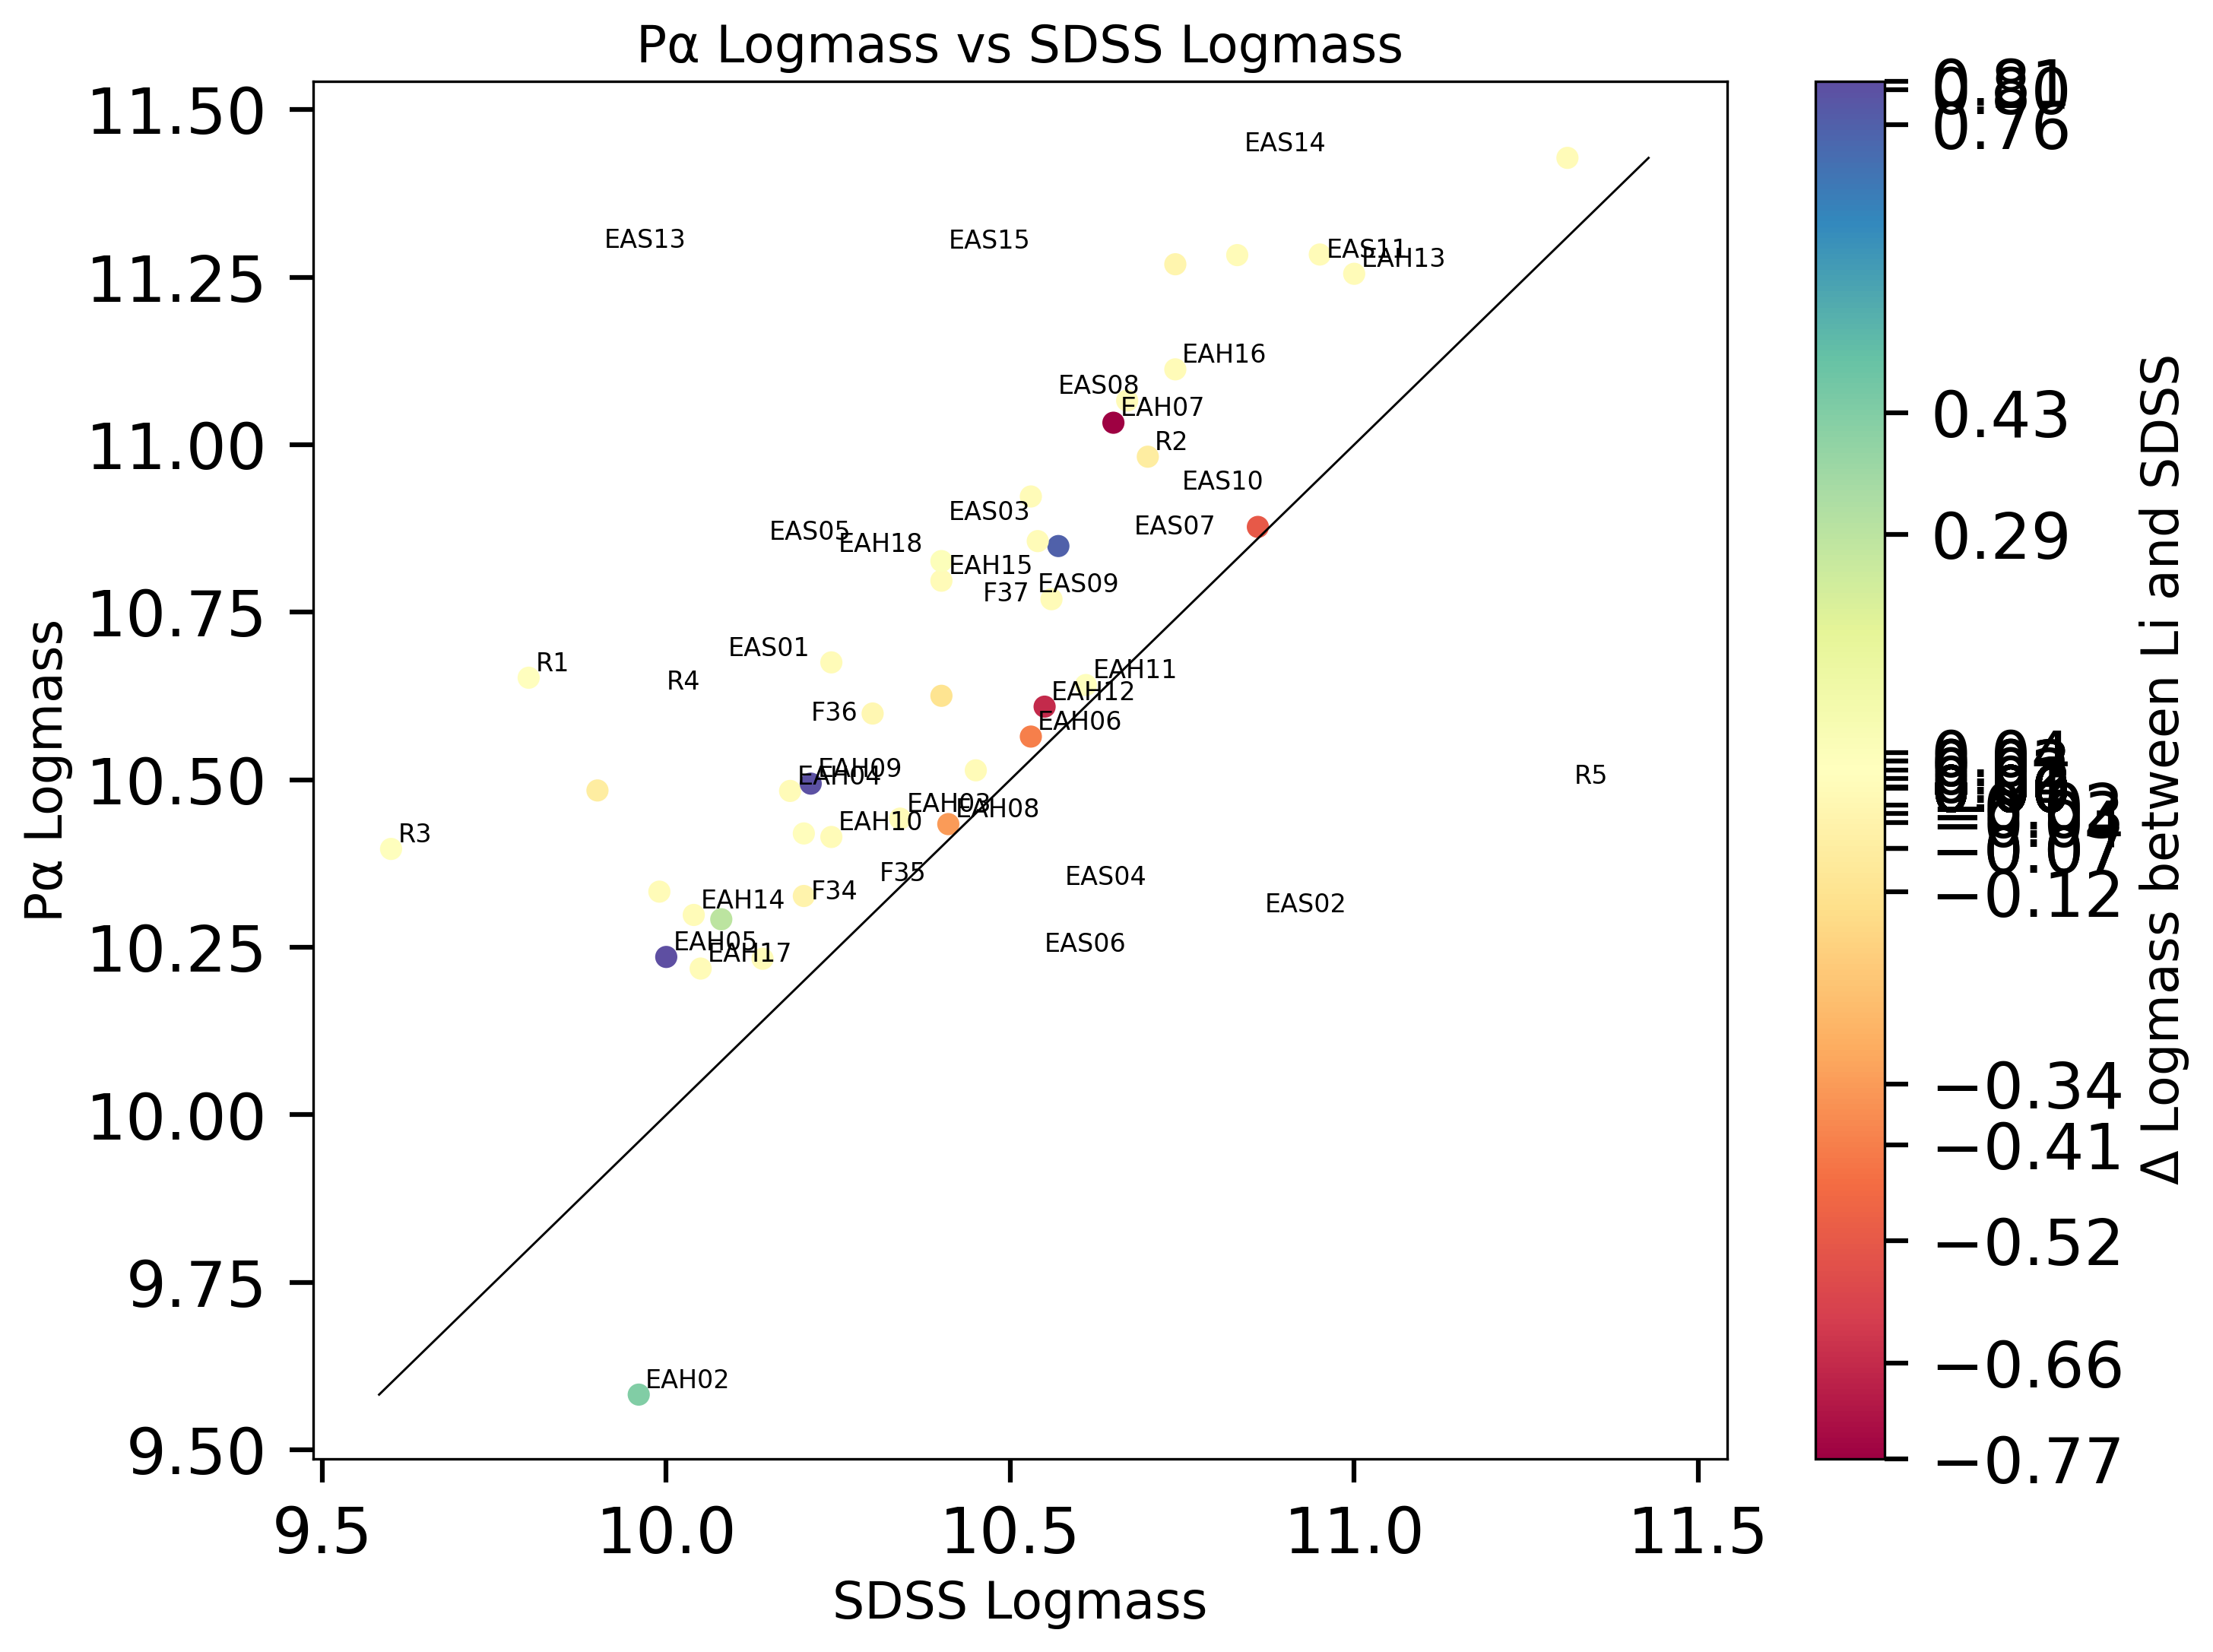

In [ ]:
### Plot Pα Simulated Logmass vs SDSS Logmass ###
counter = 0
sorted_SDSS_logmass_4SDSS = []
sorted_Pa_logmass_4SDSS = []
sorted_Li_logmass_4SDSS = []
sorted_G_numbers_4SDSS = []
sorted_Pa_logmass = []
for i in G_numbers:
    if Logmass_mask[i] == True:
        sorted_G_numbers_4SDSS.append(i)
        sorted_SDSS_logmass_4SDSS.append(SDSS_Logmass[i])
        sorted_Pa_logmass_4SDSS.append(logmass[counter])
        sorted_Li_logmass_4SDSS.append(Gal_logmass[counter])
        sorted_Pa_logmass.append(logmass[counter])
    counter += 1

sorted_SDSS_logmass_4SDSS = np.array(sorted_SDSS_logmass_4SDSS)
sorted_Li_logmass_4SDSS = np.array(sorted_Li_logmass_4SDSS)
sorted_Pa_logmass_4SDSS = np.array(sorted_Pa_logmass_4SDSS)
sorted_G_numbers_4SDSS = np.array(sorted_G_numbers_4SDSS)


fig = figure(figsize=(10,8))

xlim(logmass_min * 0.99, logmass_max * 1.01)
ylim(logmass_min * 0.99, logmass_max * 1.01)

title('Pα Logmass vs SDSS Logmass', size=16)
ylabel('Pα Logmass', size=16)
xlabel('SDSS Logmass', size= 16)

plot(logmass_line_lin, logmass_line_lin, 'k')
scatter(sorted_SDSS_logmass_4SDSS, sorted_Pa_logmass, c=(sorted_Li_logmass_4SDSS - sorted_SDSS_logmass_4SDSS), cmap='Spectral')

cbar = colorbar(ticks = (sorted_Li_logmass_4SDSS - sorted_SDSS_logmass_4SDSS))
cbar.set_label(label=r'$\Delta$ Logmass between Li and SDSS', size=16)


for i, txt in enumerate(sorted_G_numbers_4SDSS):
    annotate(Gal_desig[i], (sorted_SDSS_logmass_4SDSS[i] + offset, logmass[i] + offset), size = 8)        #str(txt) + ','+ 

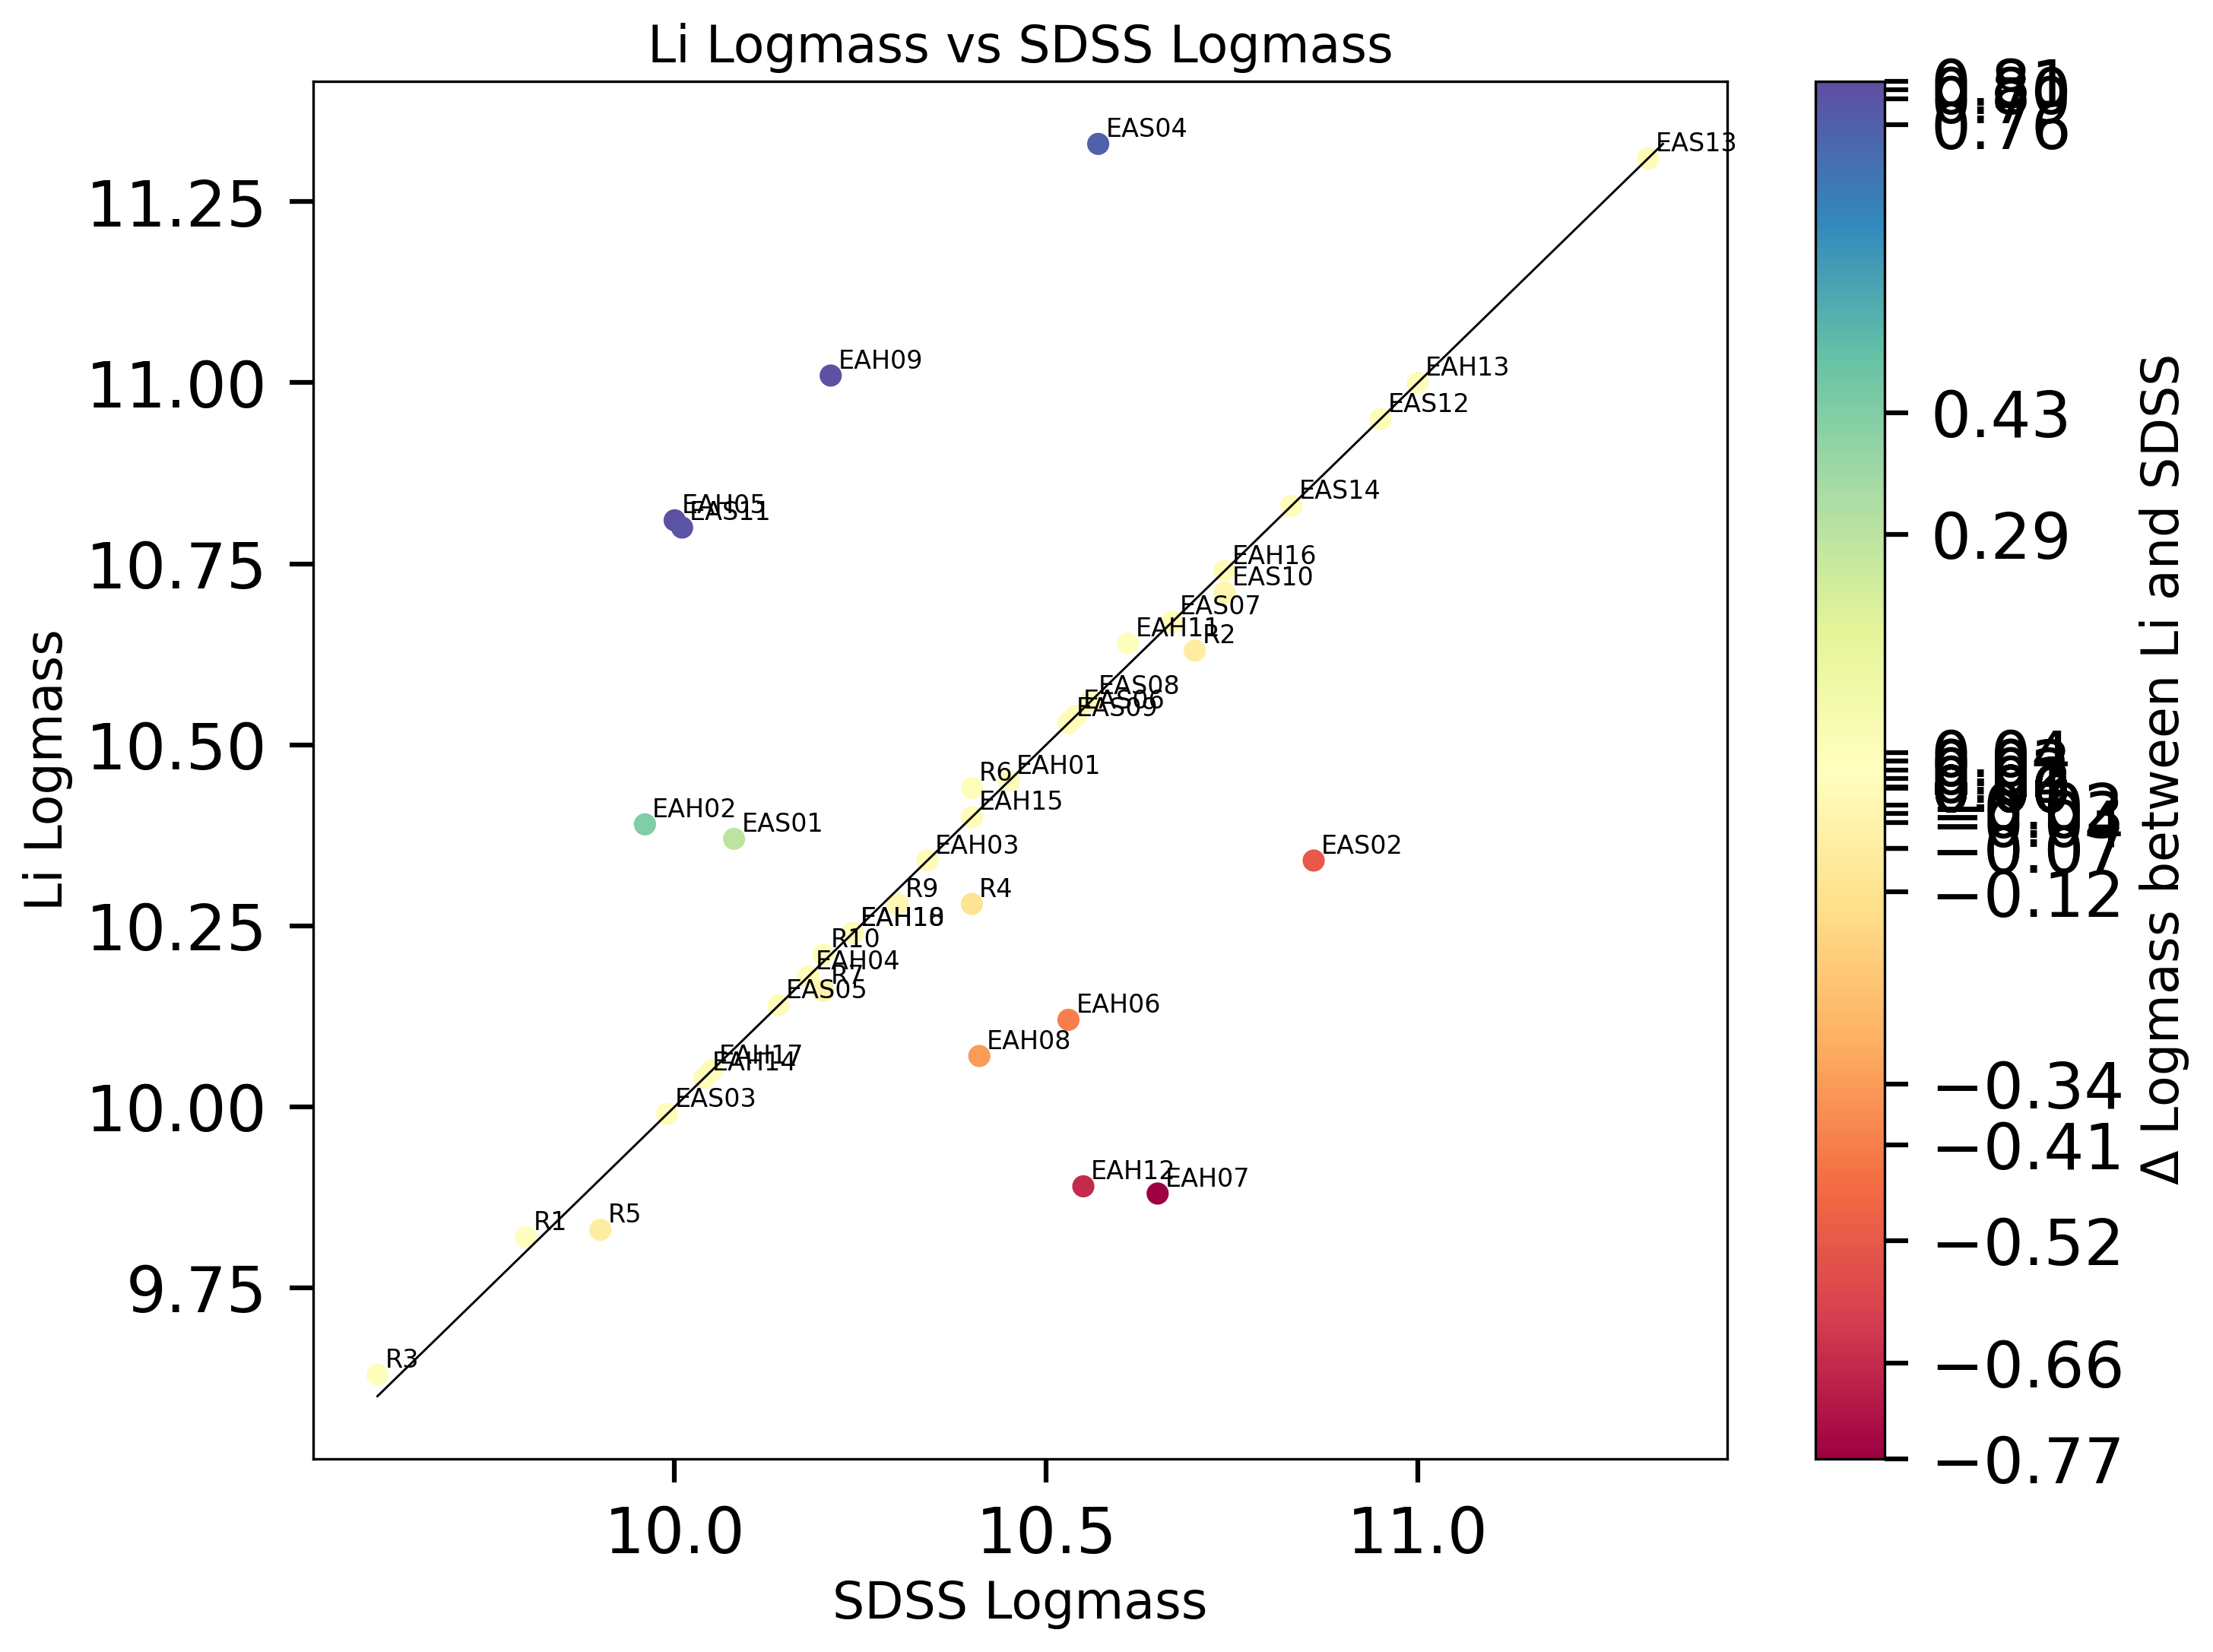

In [ ]:
### Compare Li et al Logmass to SDSS Logmass ###
All_Li_logmass = []
SDSS_G_numbers = []
All_G_desig = []

for i in range(0, 58):
    All_Li_logmass.append(AGN_data[i][50])
    SDSS_G_numbers.append(i)
    All_G_desig.append(AGN_data[i][1])

All_Li_logmass = np.array(All_Li_logmass)
SDSS_G_numbers = np.array(SDSS_G_numbers)

All_SDSS_Logmass = SDSS_Logmass[Logmass_mask]
All_Li_logmass = All_Li_logmass[Logmass_mask]
SDSS_G_numbers = SDSS_G_numbers[Logmass_mask]

SDSS_logmass_min = min(min(All_SDSS_Logmass), min(All_Li_logmass))
SDSS_logmass_max = max(max(All_SDSS_Logmass), max(All_Li_logmass))
SDSS_logmass_line_lin = np.linspace(SDSS_logmass_min, SDSS_logmass_max, num=100)

fig = figure(figsize=(10,8))

title('Li Logmass vs SDSS Logmass', size=16)
ylabel('Li Logmass', size=16)
xlabel('SDSS Logmass', size= 16)

plot(SDSS_logmass_line_lin, SDSS_logmass_line_lin, 'k')
scatter(All_SDSS_Logmass, All_Li_logmass, c=(All_Li_logmass - All_SDSS_Logmass), cmap='Spectral')

cbar = colorbar(ticks = (All_Li_logmass - All_SDSS_Logmass))
cbar.set_label(label=r'$\Delta$ Logmass between Li and SDSS', size=16)


for i, txt in enumerate(SDSS_G_numbers):
    annotate(All_G_desig[i], (All_SDSS_Logmass[i] + offset, All_Li_logmass[i] + offset), size = 8)        #str(txt) + ','+ 

In [ ]:
end_time = time.time()
print('This program takes:\n\t',end_time - start_time, '\tsecs\n\t', (end_time - start_time)/60, '\tmins\n\t', (end_time - start_time)/60/60, '\thours')

This program takes:
	 435.0419237613678 	secs
	 7.25069872935613 	mins
	 0.12084497882260217 	hours
